<a href="https://colab.research.google.com/github/GurjeetSinghSangra/MachineLearningAssignment/blob/main/emnist_DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-plot
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.6/dist-packages/
# create a symbolic link between the downloaded libfaiss.so file and the location python's looking at
!echo $LD_LIBRARY_PATH 
# this is probably /usr/lib64-nvidia
!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

#%matplotlib tk
##################################################
# Imports
##################################################
import numpy as np
import numpy.matlib
import math
import scipy.io
from sklearn import svm, datasets
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn #torch made by layers, in nn we have linear layer which implements standard forward fully connected layer
import torch.nn.functional as F 
import torchvision #used for data loading
import torch.optim as optim #optimizer for the gradient
from tqdm.notebook import tqdm
import time
import scikitplot as skplt
import matplotlib.gridspec as gridspec
from skimage.util import random_noise
import pandas as pd


# Setting the device
if torch.cuda.is_available(): 
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
 

--2021-01-23 07:33:30--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a95778a870c42137059?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda100.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda100.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20210123T073330Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEPX%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIEGWI2yEJpQKhhMh46OBsJrnhEHo%2BHrNof7p74mgAcBHAiEA4%2B1rLkInflQi54w3rMS8v9GpqoxGbIyLtgkGewZ9haEqvQMIzv%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARAAGgw0NTU4NjQwOTgzNzgiDD%

## DBN Model

In [2]:
class DBN(nn.Module):

  def __init__(self, layers_nn, maxepochs=50, batchsize=150, epsilonw=0.1, \
                               sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):
    super(DBN, self).__init__()
    self.DN = {}
    self.DN['layersize'] = layers_nn
    self.DN['nlayers'] = len(layers_nn)
    self.DN['batchsize'] = batchsize
    self.DN['maxepochs'] = maxepochs
    self.epsilonw_GPU = epsilonw #learning rate DeltaW = epsilonw (pos_v * pos_h - neg_v * neg_h)
    self.epsilonvb=epsilonvb
    self.epsilonhb=epsilonhb
    self.weightcost = weightcost #constant weight decrease
    self.initialmomentum = init_momentum
    self.finalmomentum = final_momentum
    self.sparsity = sparsity
    self.spars_factor = spars_factor
    self.DN['errors'] = {}
  
  def train_dbn(self, batch, device):

    batchdata = torch.Tensor(batch).to(device)
    nlayers = self.DN['nlayers']
    for layer in range(0, nlayers):
        print ('Training layer ', layer+1, '...')
        if layer == 0:
            data_GPU = batchdata
        else:
            data_GPU = batchposhidprobs
        
        numhid = self.DN['layersize'][layer]
        numcases, numdims, numbatches = data_GPU.shape
        vishid_GPU       = 0.1 * torch.randn(numdims, numhid, device=device) #normal dist weights with standard deviation 0.01
        #print(vishid_GPU.shape)
        hidbiases_GPU    = torch.zeros(numhid, device=device)
        visbiases_GPU    = torch.zeros(numdims, device=device)
        vishidinc_GPU    = torch.zeros((numdims, numhid), device=device)
        hidbiasinc_GPU   = torch.zeros(numhid, device=device)
        visbiasinc_GPU   = torch.zeros(numdims, device=device)
        batchposhidprobs = torch.zeros((numcases, numhid, numbatches), device=device)
        self.DN['errors'][layer] = []


        sigmoid = nn.Sigmoid()
        for epoch in range(self.DN['maxepochs']):
            errsum = 0
            for mb in range(numbatches):
                data_mb = data_GPU[:, :, mb]
                #%%%%%%%% START POSITIVE PHASE %%%%%%%%%
                #1./(1 + exp(-poshidstates * vishid' - repmat(visbiases, numcases, 1))); 
                poshidprobs_GPU = sigmoid((torch.mm(data_mb, vishid_GPU) + hidbiases_GPU))#activation
                posprods_GPU    = torch.mm(data_mb.T, poshidprobs_GPU) #Correlations visibile-hidden neurons
                poshidact_GPU   = poshidprobs_GPU.sum(0) #needed for hidden bias inc.
                posvisact_GPU   = data_mb.sum(0) #needed for positive bias inc.
                #%%%%%%%% END OF POSITIVE PHASE %%%%%%%%%
                poshidstates_GPU = poshidprobs_GPU > (torch.rand(numcases, numhid, device=device))
                poshidstates_GPU = torch.gt(poshidstates_GPU, 0).float() #sampling of activated neurons

                #%%%%%%%% START NEGATIVE PHASE  %%%%%%%%%
                negdata_GPU     = sigmoid((torch.mm(poshidstates_GPU, vishid_GPU.T) + visbiases_GPU))
                neghidprobs_GPU = sigmoid((torch.mm(negdata_GPU, vishid_GPU) + hidbiases_GPU))
                negprods_GPU    = torch.mm(negdata_GPU.T, neghidprobs_GPU) #correlation
                neghidact_GPU   = neghidprobs_GPU.sum(0)
                negvisact_GPU   = negdata_GPU.sum(0)
                #%%%%%%%% END OF NEGATIVE PHASE %%%%%%%%%
                
                err = torch.sqrt(torch.sum(torch.sum((data_mb - negdata_GPU)**2, dim=0)))
                if self.DN['maxepochs']  > 5:
                  self.momentum = self.finalmomentum
                else:
                  self.momentum = self.initialmomentum

                #%%%%%%%% UPDATE WEIGHTS AND BIASES %%%%%%%%%
                vishidinc_GPU  = vishidinc_GPU  * self.momentum + self.epsilonw_GPU * ((posprods_GPU - negprods_GPU) / numcases - self.weightcost * vishid_GPU)
                visbiasinc_GPU = visbiasinc_GPU * self.momentum + (posvisact_GPU - negvisact_GPU) * (self.epsilonvb / numcases)
                hidbiasinc_GPU = hidbiasinc_GPU * self.momentum + (poshidact_GPU - neghidact_GPU) * (self.epsilonhb / numcases)
                vishid_GPU     = vishid_GPU + vishidinc_GPU
                visbiases_GPU  = visbiases_GPU + visbiasinc_GPU
                hidbiases_GPU  = hidbiases_GPU + hidbiasinc_GPU
                #%%%%%%%% END OF UPDATES %%%%%%%%%
                # END RBM
                
                errsum = err + errsum

                if epoch == self.DN['maxepochs']-1:
                    batchposhidprobs[:, :, mb] = poshidprobs_GPU

                #Sparsity
                if self.sparsity and (layer == nlayers-1):
                  #poshidact_GPU = poshidprobs_GPU.sum(0)
                  Q = poshidact_GPU / self.DN['batchsize']
                  if (torch.mean(Q) > self.spars_factor):
                    hidbiases_GPU = hidbiases_GPU - self.epsilonhb * (Q - self.spars_factor)
              
            #END Batches
            self.DN['errors'][layer].append((epoch, errsum.detach().cpu().numpy()))
          #END Epoches

        # save learned weights
        self.DN['vis_bias' + str(layer)] = visbiases_GPU.detach().cpu().numpy()
        self.DN['hid_bias' + str(layer)] = hidbiases_GPU.detach().cpu().numpy()
        self.DN['vishid'   + str(layer)] = vishid_GPU.detach().cpu().numpy()
        
        #print(self.DN['vishid'   + str(layer)].shape)

  def simple_load_emnist(fname): 
    dataset = scipy.io.loadmat(fname)
    data_train = dataset['dataset']['train']
    data_test = dataset['dataset']['test']
    x_train = data_train[0,0]['images'][0,0]
    x_train = x_train.astype('float32') / 255
    y_train = data_train[0,0]['labels'][0,0]
    y_train = y_train.astype(int)
    x_test = data_test[0,0]['images'][0,0]
    x_test = x_test.astype('float32')  / 255
    y_test = data_test[0,0]['labels'][0,0]
    y_test = y_test.astype(int)
    return (x_train, y_train, x_test, y_test)

  def load_data(fname, NUMB_CLASSES, batchsize):
    dataset = scipy.io.loadmat(fname)
    data_train = dataset['dataset']['train']
    data_test = dataset['dataset']['test']
    x_train = data_train[0,0]['images'][0,0]
    x_train = x_train.astype('float32') / 255
    y_train = data_train[0,0]['labels'][0,0]
    y_train = y_train.astype(int)
    x_test = data_test[0,0]['images'][0,0]
    x_test = x_test.astype('float32')  / 255
    y_test = data_test[0,0]['labels'][0,0]
    y_test = y_test.astype(int)

    iterations = int(len(x_train)/batchsize)
    batchdata = np.zeros(shape=(batchsize, 784, iterations), dtype='float32')

    for i in range(batchsize):
      for j in range(iterations):
        batchdata[i, :,j] = x_train[i*j, :]

    length_train = int(len(x_train))
    tr_labels = np.zeros(shape=(length_train, NUMB_CLASSES))
    for i in range(length_train):
        tr_labels[i, y_train[i]] = 1.0

    length_test = int(len(y_test))
    te_labels = np.zeros(shape=(length_test, NUMB_CLASSES))
    for i in range(length_test):
        te_labels[i, y_test[i]] = 1.0

    return (x_train, tr_labels, x_test, te_labels, batchdata)


  def to_string(self):
      if self.sparsity:
        sparsity_text = ' Sparse'
      else:
        sparsity_text = ''
      return "DBN: {0} {1} {2} {3}".format(str(self.DN['layersize']), \
                                             self.DN['batchsize'], \
                                             self.DN['maxepochs'], sparsity_text)
      
  def get_learned_map_features (self, input, layer_idx):
    vishid = self.DN['vishid' + str(layer_idx)]
    hid_bias = self.DN['hid_bias' + str(layer_idx)]
    H_feature = 1 /(1 + np.exp(-np.dot(input, vishid) - np.matlib.repmat(hid_bias, len(input), 1)));
    return H_feature
  

## Utils Functions

In [3]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
def save_to_matlab_model(dbn_model):
  savematname = 'DN_COLAB_{0}.mat'.format(dbn_model.to_string())
  scipy.io.savemat(savematname, {'DN': dbn_model.DN})

np.set_printoptions(precision=2)        
#images = np.apply_along_axis(rotate, 1, x_train)
#plt.imshow(images[1,], cmap=plt.get_cmap('gray')) 

In [4]:
class HyperParameterConf:
####### HYPER PARAMTERS of DBN ####################
# layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1,
# sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, 
# weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):

  def __init__(self, layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1, \
               sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, \
               weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):
    
    self.layers = layers_nn
    self.batchsize= batchsize
    self.maxepochs = maxepochs
    self.epsilonw = epsilonw #learning rate DeltaW = epsilonw (pos_v * pos_h - neg_v * neg_h)
    self.epsilonvb=epsilonvb
    self.epsilonhb=epsilonhb
    self.weightcost = weightcost #constant weight decrease
    self.init_momentum = init_momentum
    self.final_momentum = final_momentum
    self.sparsity = sparsity
    self.spars_factor = spars_factor
  
  def get_dbn_model(self):
    return DBN(layers_nn=self.layers, maxepochs=self.maxepochs, \
               batchsize=self.batchsize, epsilonw=self.epsilonw, \
               sparsity=self.sparsity, spars_factor=self.spars_factor, \
               epsilonvb=self.epsilonvb, epsilonhb=self.epsilonhb, \
               weightcost=self.weightcost, init_momentum=self.init_momentum, \
               final_momentum=self.final_momentum)
    
  def to_string(self):
      if self.sparsity:
        sparsity_text = ' Sparse'
      else:
        sparsity_text = ''
      return "DBN: {0}, {1}, {2} {3}".format(str(self.layers), \
                                             self.batchsize, \
                                             self.maxepochs, sparsity_text)
  

In [5]:
def plot_accuracies (dbn_title, dbn_idx, results, axis):
  width=0.35
  tr_accuracies = [results[0][0]['tr_accuracy']]
  te_accuracies = [results[0][0]['te_accuracy']]
  #concatate first results with others
  
  tr_accuracies = tr_accuracies + list(map(lambda val: val['tr_accuracy'], results[dbn_idx]))
  te_accuracies = te_accuracies + list(map(lambda val: val['te_accuracy'], results[dbn_idx]))
  tr_accuracies = np.array(tr_accuracies) * 100
  te_accuracies = np.array(te_accuracies) * 100

  x = np.arange(len(results[dbn_idx])+1) 
  print(tr_accuracies)
  print(tr_accuracies)
  print(x - width/2)
  bar_tr = axis.bar(x - width/2, tr_accuracies, width, label='Train. Acc.')
  bar_te = axis.bar(x + width/2, te_accuracies, width, label='Test Acc.')
  axis.set_xticks(x)
  x_labels = list(map(lambda value : 'Layer {0}'.format(value), x))
  x_labels[0] = 'Pixels'
  axis.set_xticklabels(x_labels)
  axis.legend(loc='upper left')
  axis.set_label("Percentage")
  axis.set_title("Read-outs Acc. {0}".format(dbn_title))
  minimum = min(tr_accuracies.min(), te_accuracies.min())
  if minimum > 5:
    minimum -= 4
  axis.set_ylim(minimum, 100)
  autolabel(bar_tr, axis)
  autolabel(bar_te, axis)

In [6]:
ascii_fun = np.vectorize(lambda x: chr(x))

def balanced_map_labels(label):
  if label < 10:
    return label + 48
  elif label < 36:
    return label + 55
  elif label <38:
    return label + 61
  elif label < 43:
    return label + 62
  elif label == 43:
    return label + 67
  elif label < 46:
    return label + 69
  else:
    return 116 #46

letters_map_fun = np.vectorize(lambda x: x+64)
balanced_map_fun = np.vectorize(balanced_map_labels)

def plot_errors(dbn_model, axis, idx_model):
  nlayers = dbn_model.DN['nlayers']
  legends = []
  legend_name = []
  for layer in range(nlayers):
    values = dbn_model.DN['errors'][layer]
    x, y = zip(*values)
    leg,  = axis.plot(x, y)
    legends.append(leg)
    legend_name.append('L{0}'.format(layer+1))

  axis.legend(legends, legend_name, loc='upper right', shadow=True)
  title = 'Errors DBN model {0}'.format(idx_model)
  axis.set_title(title)

def plot_conf_matrix(y_test, pred, title, axes, namedataset):
  y_label_dec = np.argmax(y_test, axis=1)  
  y_label_pred = np.argmax(pred, axis=1)
  if namedataset == 'letters':
    y_label_dec = letters_map_fun(y_label_dec)
    y_label_pred = letters_map_fun(y_label_pred)
  else:
    y_label_dec = balanced_map_fun(y_label_dec)
    y_label_pred = balanced_map_fun(y_label_pred)
  y_label_dec = ascii_fun(y_label_dec)
  y_label_pred = ascii_fun(y_label_pred)
  skplt.metrics.plot_confusion_matrix(
      y_label_dec, 
      y_label_pred, normalize=True, title=title, ax = axes)

In [7]:
def plot_visihidlayers(DN, idx_layers, n_hidden, figsize):

  v, h = DN['vishid0'].shape # number of visible and hidden units
  imgsize = int(math.sqrt(v));
  if n_hidden > h:
      n_hidden = h;

  n_x = math.floor(math.sqrt(n_hidden))
  n_y = n_x
  n_hidden = n_x * n_y;

  
  for layer in idx_layers:
    row = 0
    column = 0
    fig, axes = plt.subplots(n_x, n_x, figsize=figsize)
    fig.suptitle("Visible Hidd. Layer {0}".format(layer+1), fontsize=14)

    ## Visible hidden neuron sum weights calculation
    for i_n in range(n_hidden):
      prev_weights = None
      for id_layer in range(layer+1) :
        vishidname = 'vishid{0}'.format(id_layer)
        if id_layer == layer:
          weights = DN[vishidname][:, i_n]
        else:
          weights = DN[vishidname]
        weights = np.multiply(weights, (np.abs(weights) > 0.0))
        if prev_weights is not None:
          weights = prev_weights.dot(weights)
          weights = np.multiply(weights, np.abs(weights) > 0.0)
        prev_weights = weights

      if column == n_y:
        row += 1
        column = 0
      axis = axes[row, column]
      
      axis.imshow(weights.reshape((imgsize, imgsize)), cmap=plt.cm.gray)
      column +=1

    plt.show()


In [8]:
from scipy.linalg import lstsq

def predict(model_weight, x, labels, addbias=True):
  if addbias:
    x_m =  np.hstack((x, np.ones((len(x), 1))))
  else:
    x_m = x
  pred = np.dot(x_m, model_weight)
  max_act_idx = np.argmax(pred, axis=1)
  r = np.nonzero(labels)[1]
  acc = (max_act_idx == r)
  return (np.mean(acc), pred)

def perceptron_CPU(tr_patterns, tr_labels, te_patterns, te_labels):

  te_accuracy = 0;
  tr_accuracy = 0;

  # add biases and train perceptron
  tr_patterns_CPU = np.hstack((tr_patterns, np.ones((len(tr_patterns), 1))))
  weights, res, rnk, s= lstsq(tr_patterns_CPU, tr_labels) 
  # training accuracy
  tr_accuracy, pred = predict(weights, tr_patterns_CPU, tr_labels, addbias=False)

  # test accuracy
  te_accuracy, pred = predict(weights, te_patterns, te_labels)
  accur = {"tr_accuracy": tr_accuracy, "te_accuracy": te_accuracy}
  return (accur, pred, weights)

def train_predict(dbn_model, input_train, output_train, input_test, output_test, layer_idx):
  vishid = dbn_model.DN['vishid' + str(layer_idx)]
  hid_bias = dbn_model.DN['hid_bias' + str(layer_idx)]
  H_tr = 1 /(1 + np.exp(-np.dot(input_train, vishid) - np.matlib.repmat(hid_bias, len(input_train), 1)));
  H_te = 1 /(1 + np.exp(-np.dot(input_test, vishid) - np.matlib.repmat(hid_bias, len(input_test), 1)));
  accuracy, pred, weights = perceptron_CPU(H_tr, output_train, H_te, output_test)
  return (accuracy, pred, weights)

## Training and Test

### Run configuration 

In [9]:
namedataset = 'mnist'
fname = ('/home/emnist-' + namedataset + '.mat')
batch_dict = {"mnist" : 125,
              "letters" : 240,
              "digits" : 200,
              "balanced" :  200}
NUMB_CLASSES = {"mnist" : int(10),
              "letters" : int(26),
              "digits" : int(10),
              "balanced" :  int(47)}

# Models to run
dbn_models_conf = []
dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([100, 500]), \
                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
                           maxepochs=20, sparsity=True))

In [10]:
namedataset = 'letters'
fname = ('/home/emnist-' + namedataset + '.mat')

batch_dict = {"mnist" : 125,
              "letters" : 240,
              "digits" : 200,
              "balanced" :  200}
NUMB_CLASSES = {"mnist" : int(10),
              "letters" : int(27),
              "digits" : int(10),
              "balanced" :  int(47)}

####### HYPER PARAMTERS of DBN ####################
# layers_nn, maxepochs=50, batchsize=125, epsilonw=0.1,
# sparsity=True, spars_factor=0.04, epsilonvb=0.1, epsilonhb=0.1, 
# weightcost=0.0002, init_momentum=0.5, final_momentum=0.9):

# Models to run
dbn_models_conf = []

dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([500, 784, 2000]), \
                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
                           maxepochs=100, sparsity=True, spars_factor=0.1))

dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([784, 1000, 1000, 2000]), \
                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
                           maxepochs=100, sparsity=True, spars_factor=0.1))
                           
dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([500, 500, 500, 2000]), \
                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
                           maxepochs=100, sparsity=False))

#dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([500, 500, 1000]), \
#                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
#                           maxepochs=100, sparsity=False))

#dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([500, 500, 500, 1000]), \
#                           epsilonw=0.1, batchsize=batch_dict[namedataset], \
#                           maxepochs=100, sparsity=False))
#dbn_models_conf.append(HyperParameterConf(layers_nn = np.array([784, 500, 500, 2000]), \
#                           epsilonw=0.3, batchsize=batch_dict[namedataset], \
#                           maxepochs=100, sparsity=True, spars_factor=0.06))


### Run

Raw Data perceptron Accuracy: 59.30, test accuracy: 57.81
DBN model 1 DBN: [ 500  784 2000] 240 100  Sparse
Training begin
Training layer  1 ...
Training layer  2 ...
Training layer  3 ...
Time diff 229
Training done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


Read out Level 1 DBN layer accuracy: 77.63, test accuracy: 77.17
Read out Level 2 DBN layer accuracy: 83.42, test accuracy: 83.19
Read out Level 3 DBN layer accuracy: 87.82, test accuracy: 87.06
[59.3  77.63 83.42 87.82]
[59.3  77.63 83.42 87.82]
[-0.17  0.82  1.82  2.83]


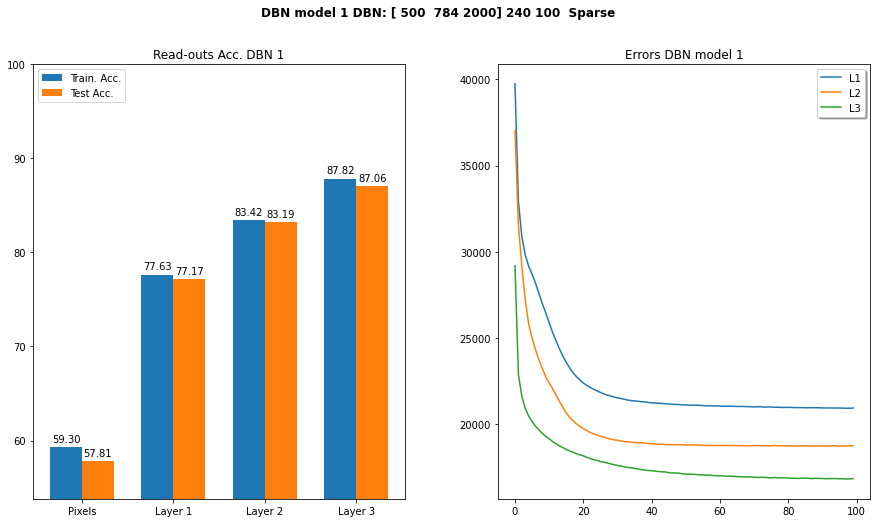

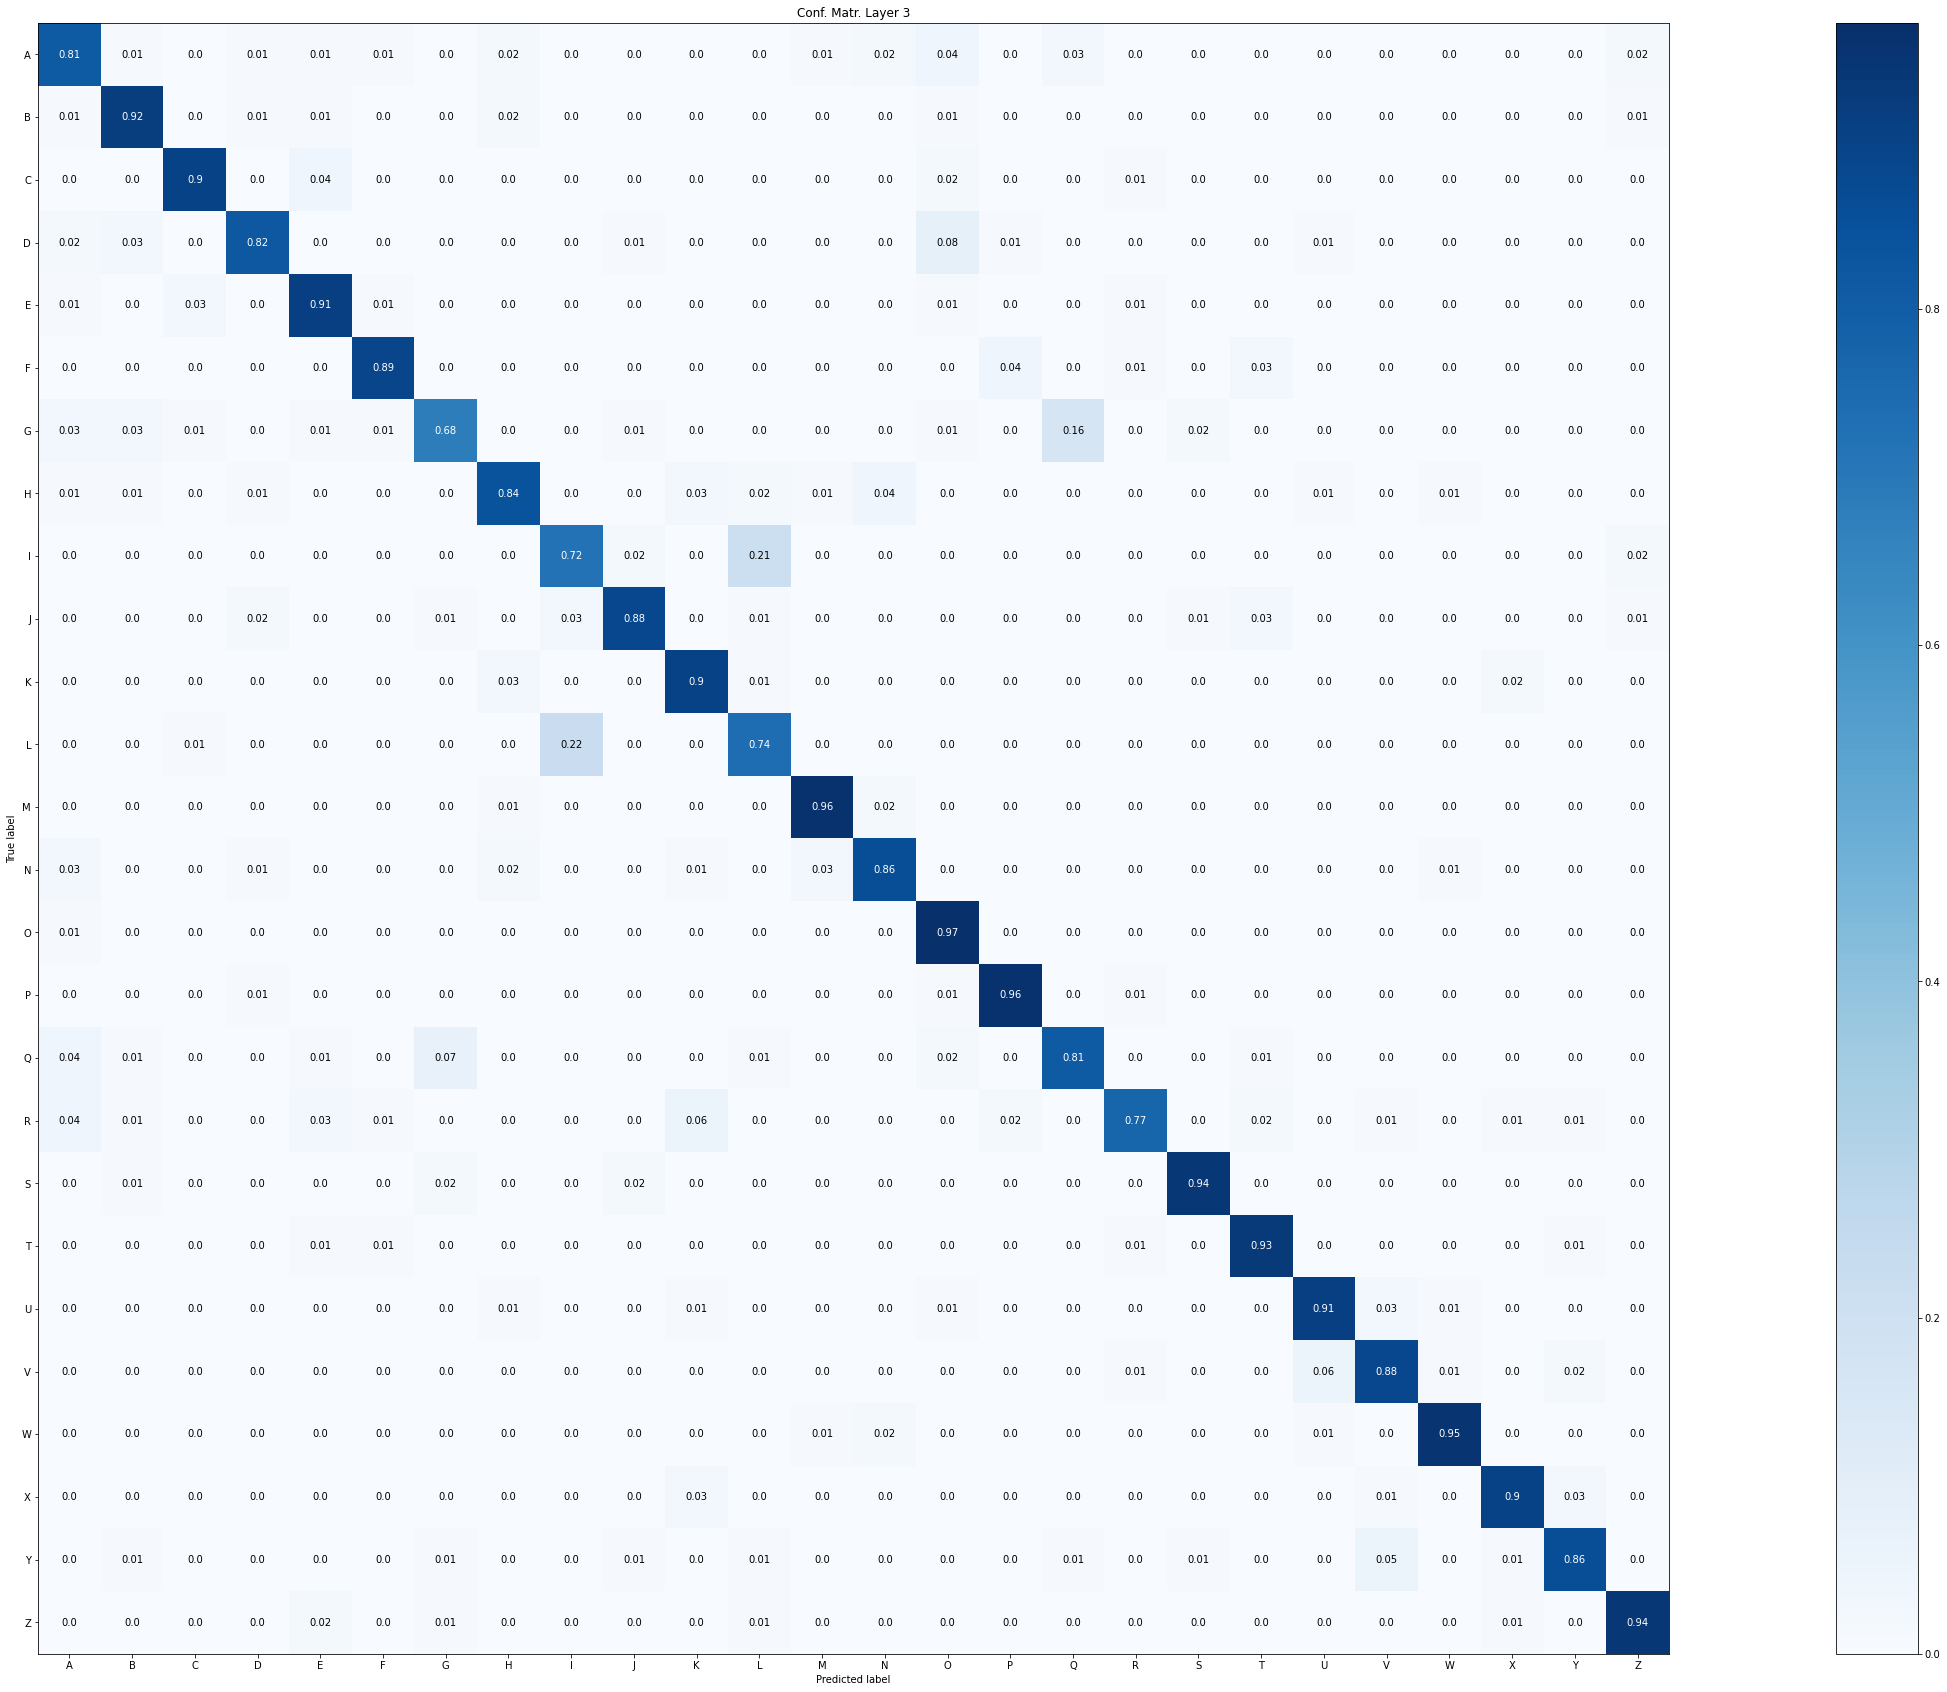

DBN model 2 DBN: [ 784 1000 1000 2000] 240 100  Sparse
Training begin
Training layer  1 ...
Training layer  2 ...
Training layer  3 ...
Training layer  4 ...
Time diff 378
Training done
Read out Level 1 DBN layer accuracy: 82.39, test accuracy: 82.00
Read out Level 2 DBN layer accuracy: 84.82, test accuracy: 84.63
Read out Level 3 DBN layer accuracy: 85.02, test accuracy: 84.49
Read out Level 4 DBN layer accuracy: 88.13, test accuracy: 87.40
[59.3  82.39 84.82 85.02 88.13]
[59.3  82.39 84.82 85.02 88.13]
[-0.17  0.82  1.82  2.83  3.83]


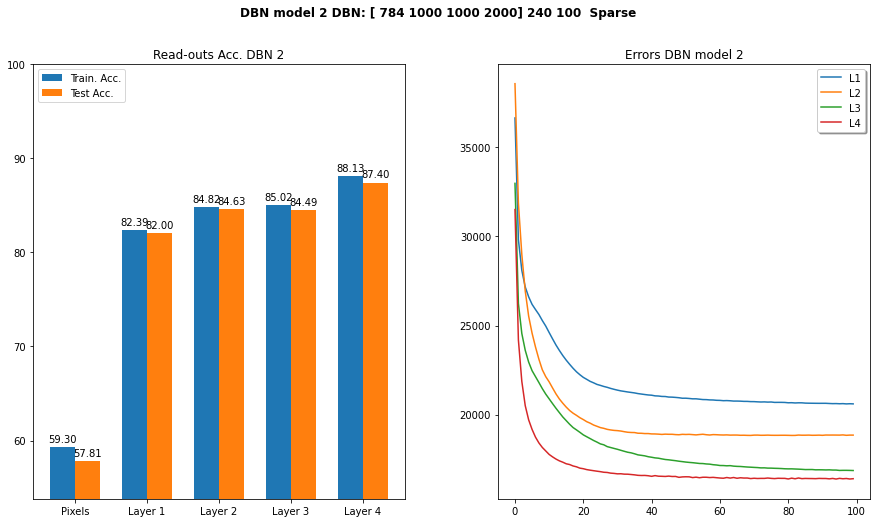

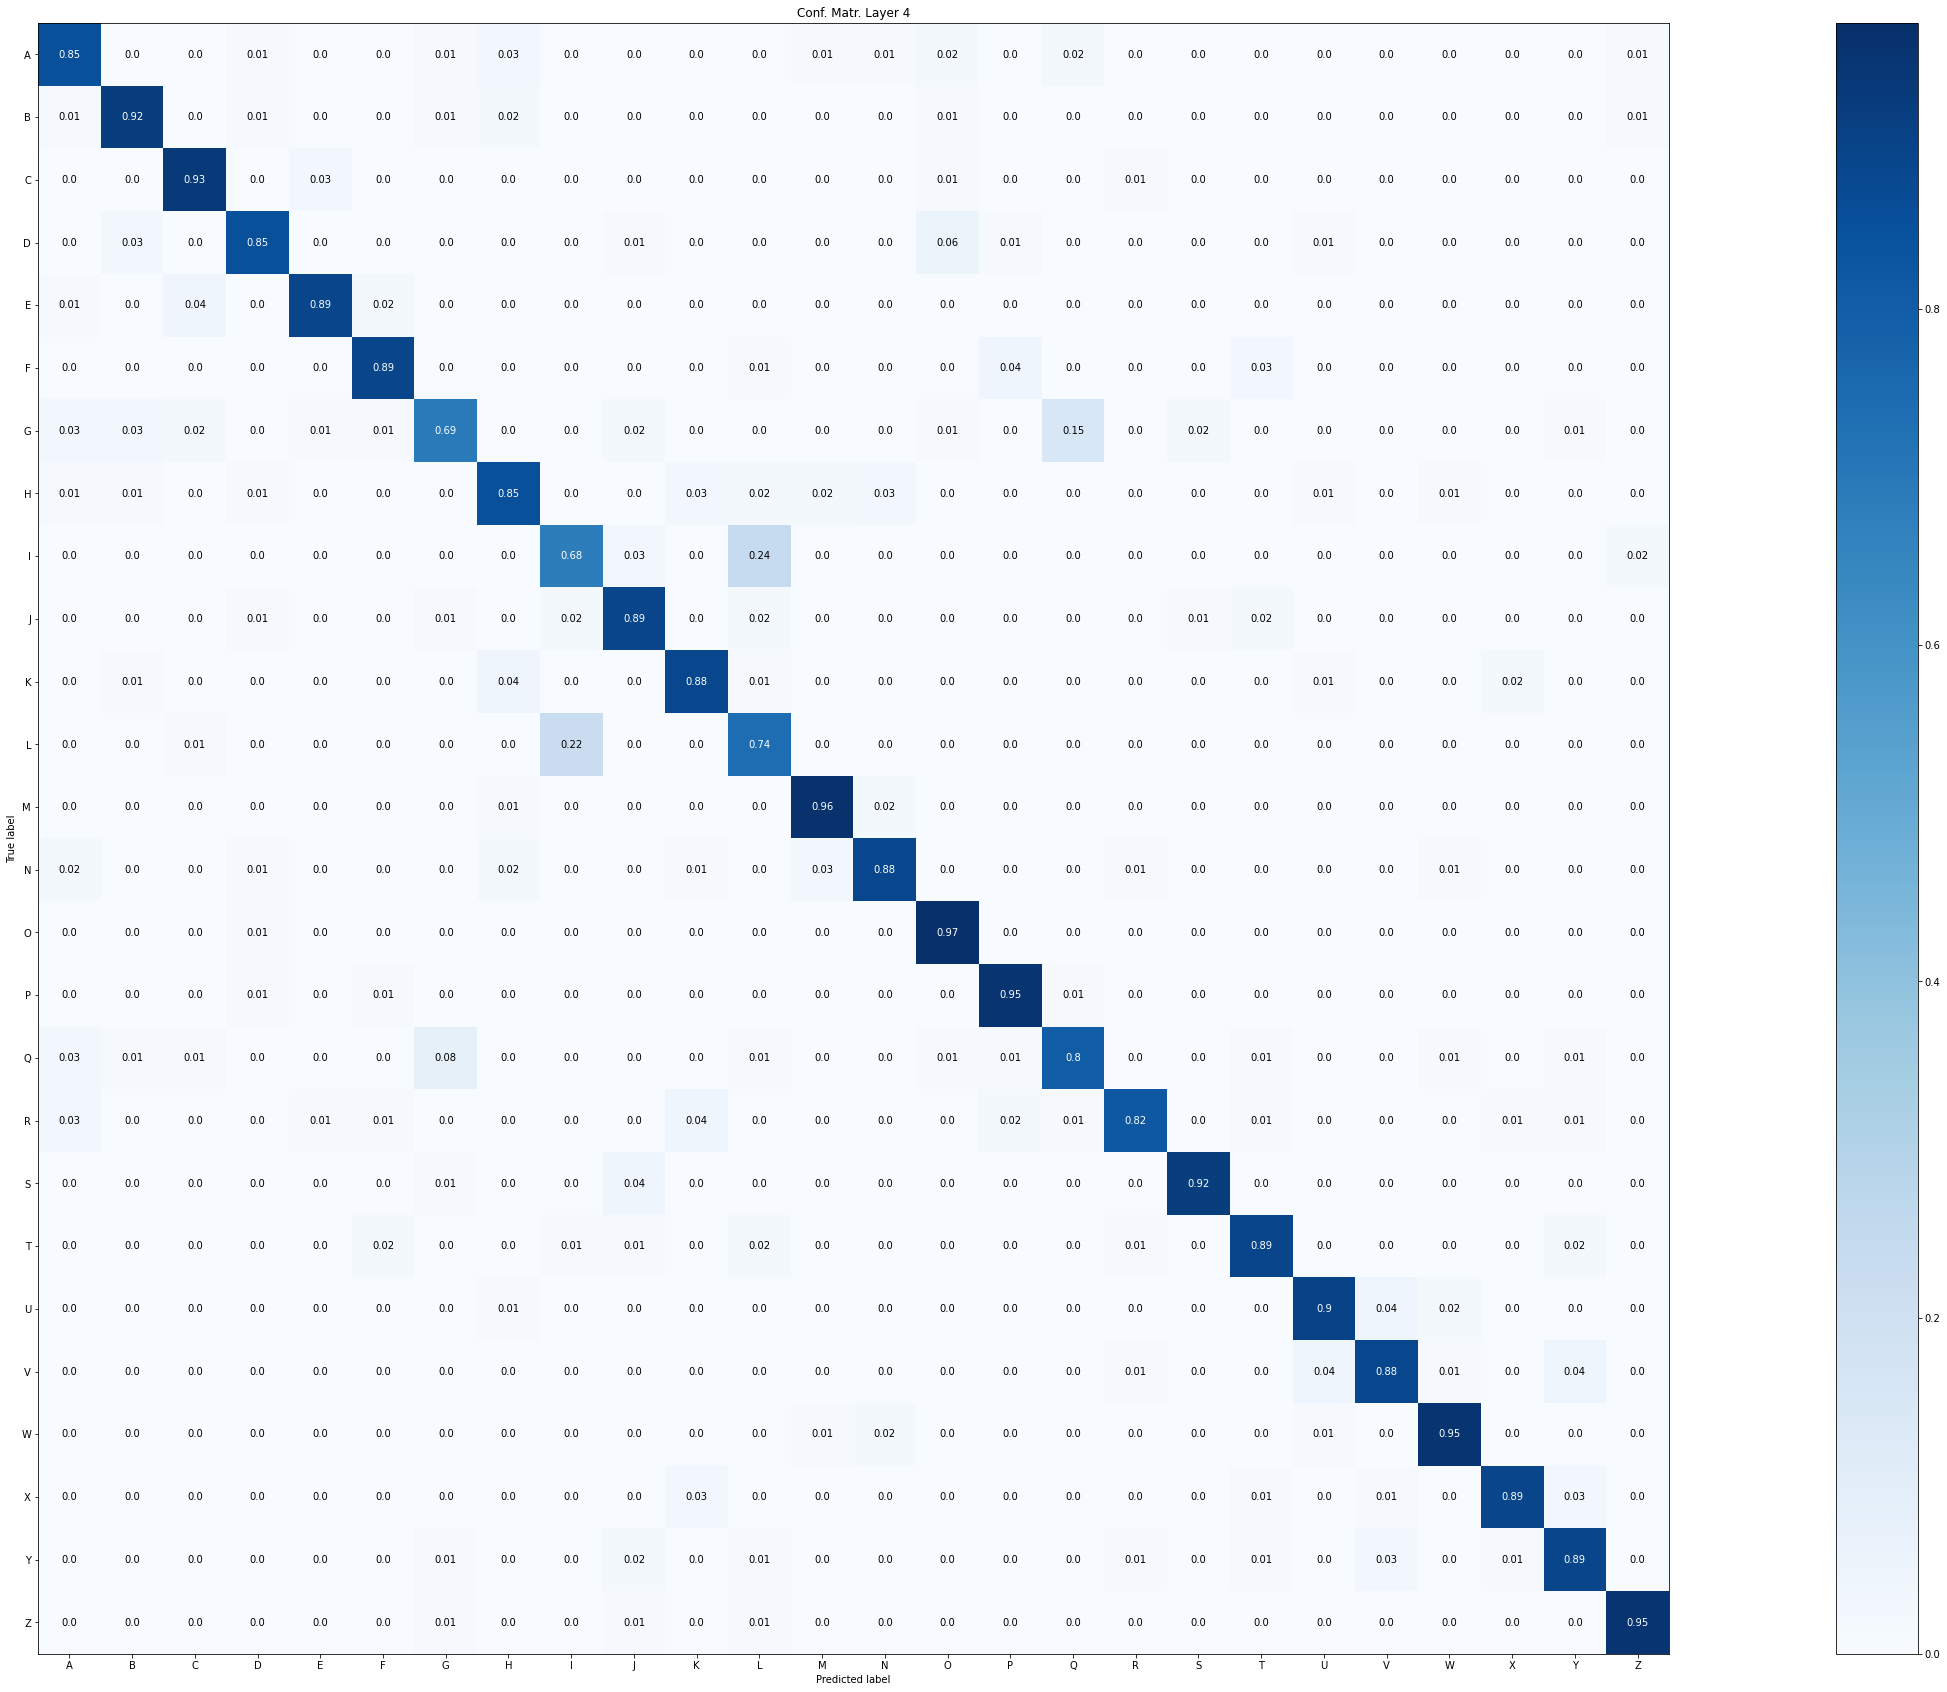

DBN model 3 DBN: [ 500  500  500 2000] 240 100 
Training begin
Training layer  1 ...
Training layer  2 ...
Training layer  3 ...
Training layer  4 ...
Time diff 221
Training done
Read out Level 1 DBN layer accuracy: 77.34, test accuracy: 76.76
Read out Level 2 DBN layer accuracy: 78.36, test accuracy: 78.08
Read out Level 3 DBN layer accuracy: 79.35, test accuracy: 79.06
Read out Level 4 DBN layer accuracy: 87.77, test accuracy: 86.76
[59.3  77.34 78.36 79.35 87.77]
[59.3  77.34 78.36 79.35 87.77]
[-0.17  0.82  1.82  2.83  3.83]


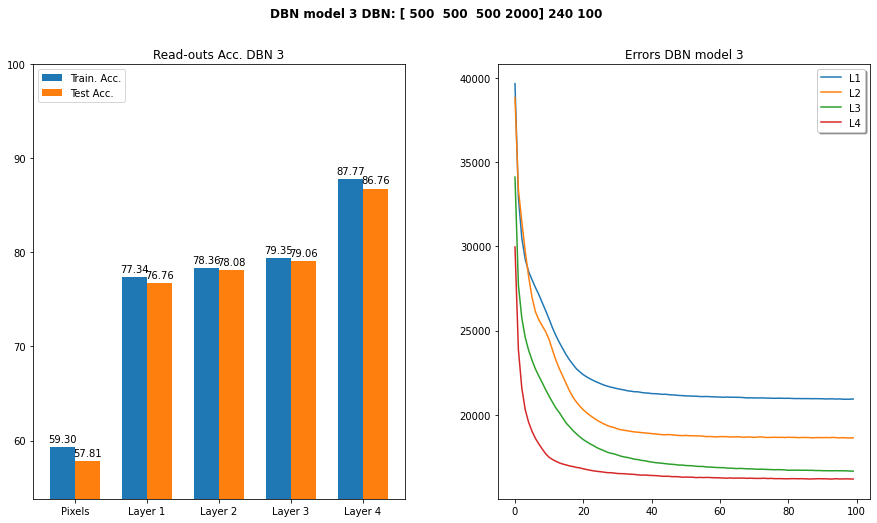

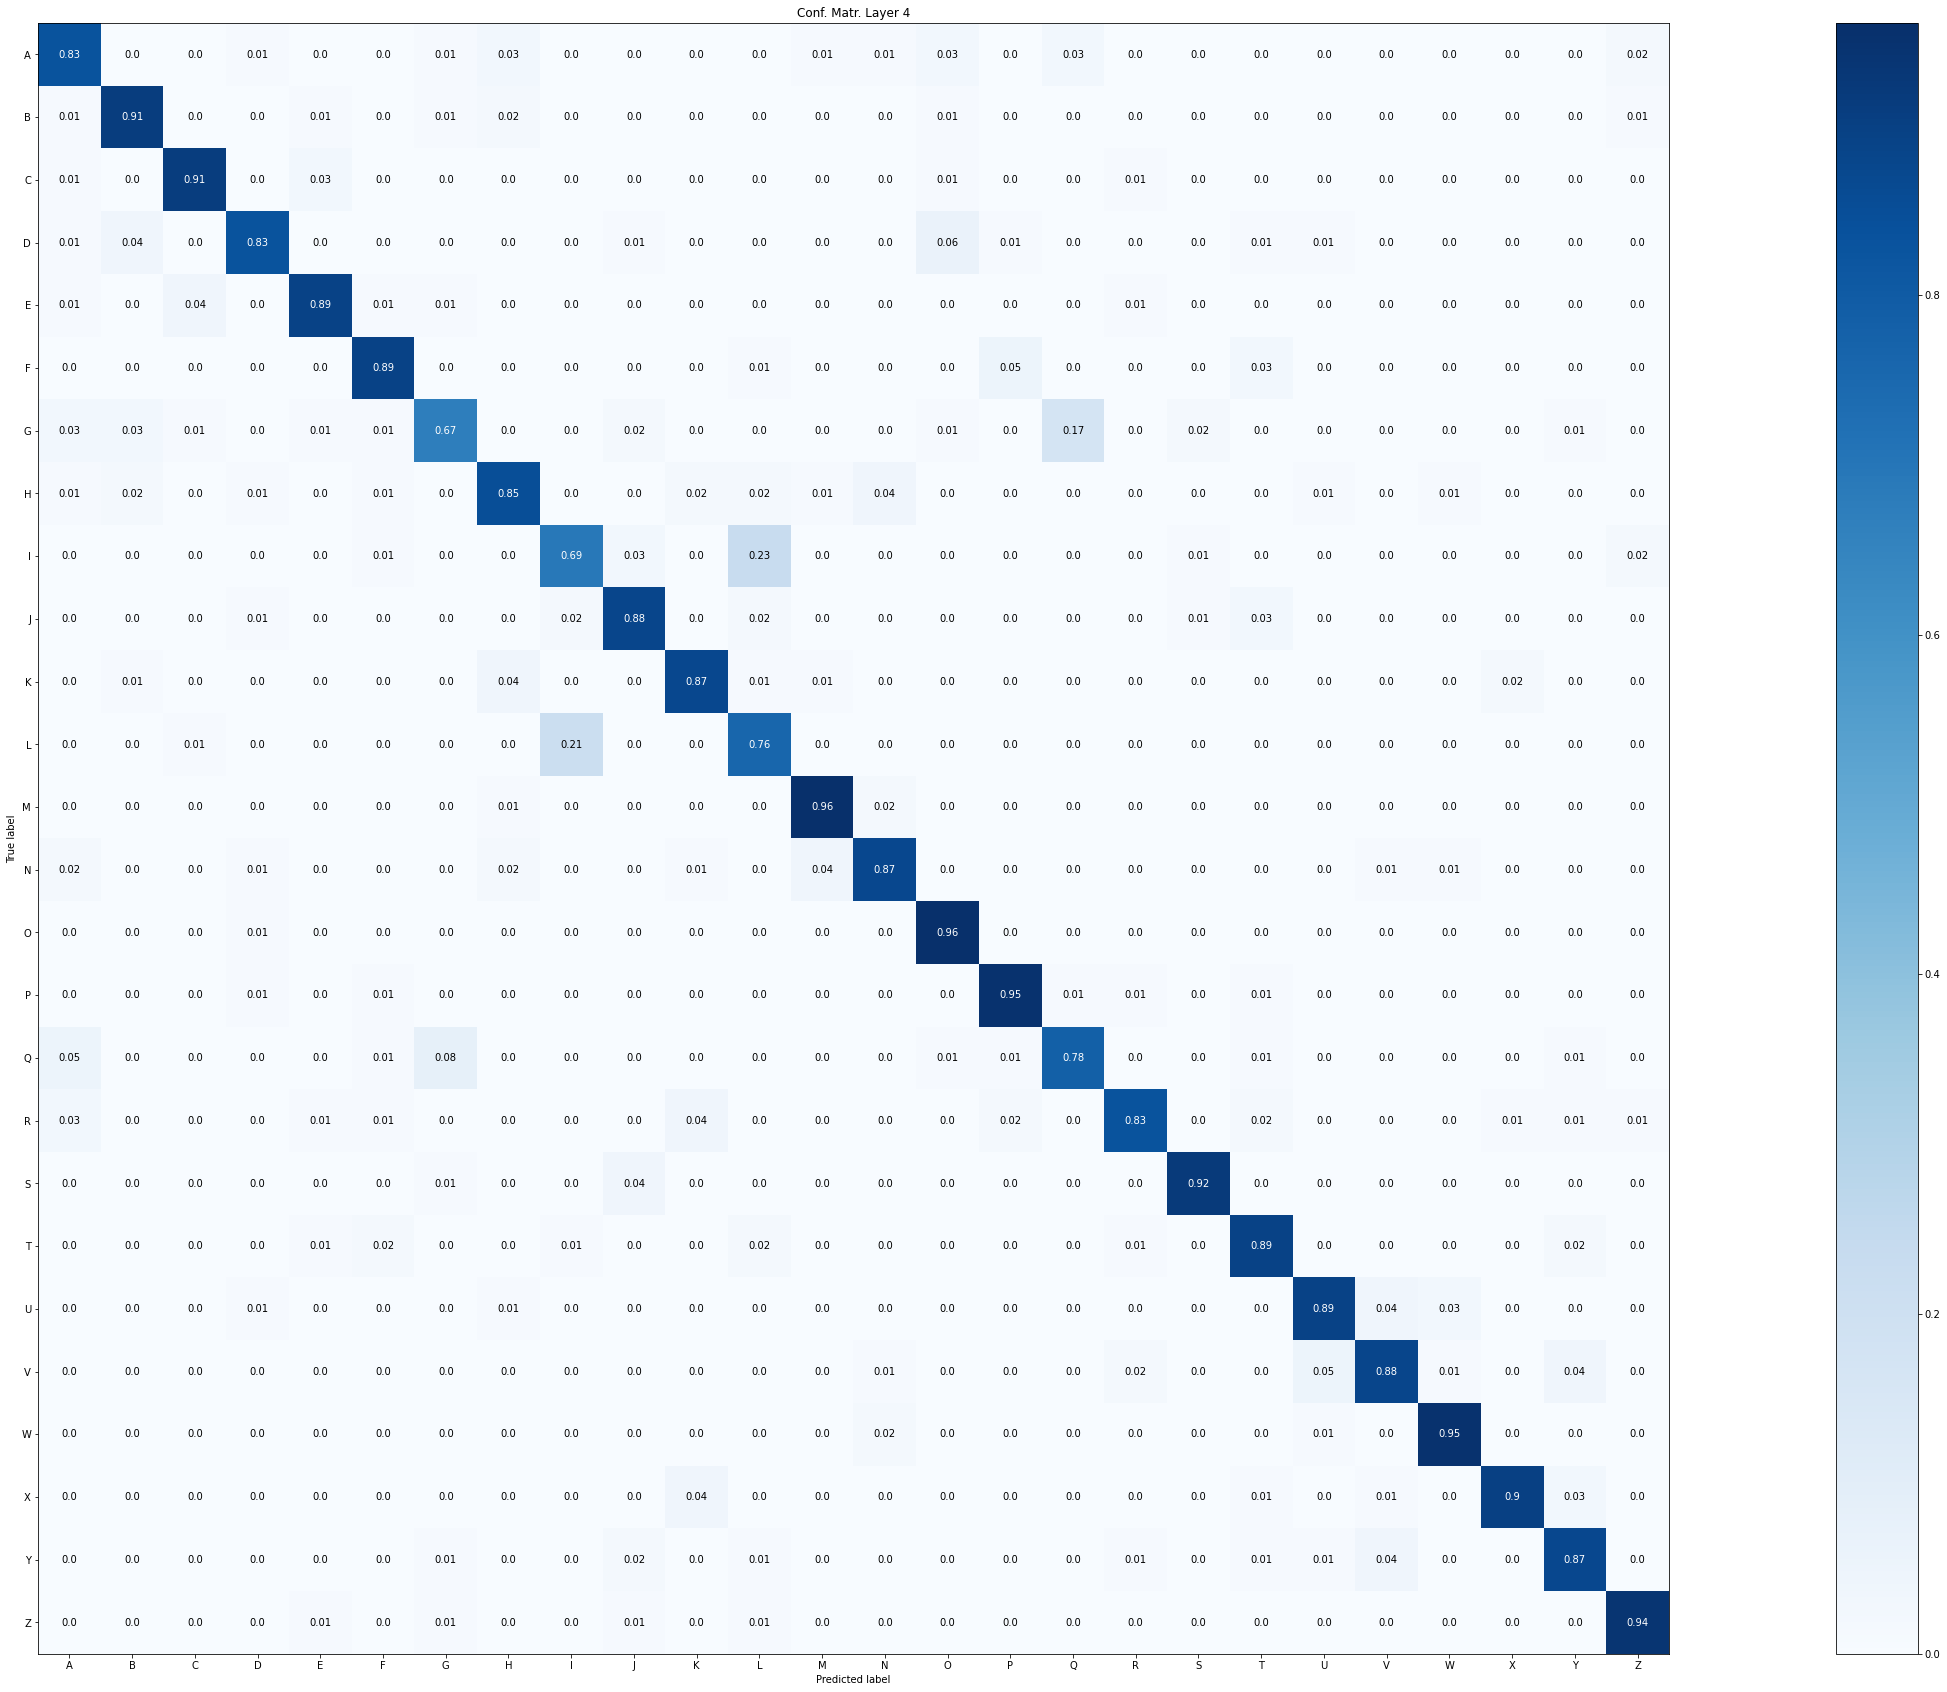

In [11]:
print_layer_matr = False
results = {}
x_train, y_train, x_test, y_test, batch_data = DBN.load_data(fname, NUMB_CLASSES[namedataset], batch_dict[namedataset])
del batch_data
accuracy, _, raw_model_weights = perceptron_CPU(x_train, y_train, x_test, y_test)
results[0] = [accuracy.copy()]
print('Raw Data perceptron Accuracy: {0:.2f}, test accuracy: {1:.2f}'.format( \
                accuracy['tr_accuracy'] * 100, accuracy['te_accuracy'] * 100))
del accuracy

n_models = len(dbn_models_conf)

i = 1

res_idx = i
prev_nlayers = 0
width=0.35
layer_model_weights = {}

for dbn_model_conf in dbn_models_conf:
  results[i] = []
  dbn_model = dbn_model_conf.get_dbn_model()
  x_train, y_train, x_test, y_test, batch_data = DBN.load_data(fname, NUMB_CLASSES[namedataset], dbn_model.DN['batchsize'])
  DBN_model_name = "DBN model {0} {1}".format(i, dbn_model.to_string())
  print(DBN_model_name)
  print('Training begin')
  x1 = time.strftime('%s')
  dbn_model.train_dbn(batch_data, device=device)
  x2 = time.strftime('%s')
  print('Time diff {0}'.format(int(x2) - int(x1)))
  print("Training done")
  
  save_to_matlab_model(dbn_model=dbn_model)
  
  nlayers = dbn_model.DN['nlayers']
  #Prepare subplots
  fig = plt.figure(i, figsize=(15, 8),constrained_layout=True)
  fig.suptitle(DBN_model_name, fontsize=12, fontweight='bold')
  fig.subplots_adjust(hspace=.25, wspace=.25)
  N_ROWS_PLOT = nlayers + 1
  N_COLUMN_PLOT = 2
  
  if not print_layer_matr:
    gs = fig.add_gridspec(nrows=1, ncols=2)
  else:
    gs = fig.add_gridspec(nrows=N_ROWS_PLOT, ncols=2)

  pred = None
  prev_train = x_train.copy()
  prev_test = x_test.copy()
  for layer_idx in range(nlayers):
    H_tr = dbn_model.get_learned_map_features(prev_train, layer_idx)
    H_te = dbn_model.get_learned_map_features(prev_test, layer_idx)
    accuracy, pred, layer_model_weights[layer_idx] = perceptron_CPU(H_tr, y_train, H_te, y_test)
    results[i].append(accuracy)
    tr_accuracy  = accuracy['tr_accuracy']
    te_accuracy = accuracy['te_accuracy'] 
    print('Read out Level {0} DBN layer accuracy: {1:.2f}, test accuracy: {2:.2f}'.format(layer_idx+1, tr_accuracy  * 100, te_accuracy  * 100))

    #PLOT Confusion Matrix
    if print_layer_matr:
      row = layer_idx + 1
      axis = fig.add_subplot(gs[row, :])
      #axis = plt.subplot2grid((N_ROWS_PLOT , N_COLUMN_PLOT), (row, 0), rowspan=4, fig=fig)
      plot_conf_matrix(y_test, pred, 'Conf. Matr. Layer {0}'.format(layer_idx+1), axis, namedataset=namedataset)
    ##
    prev_train = H_tr
    prev_test = H_te
  
  
  #axis = plt.subplot2grid((N_ROWS_PLOT , N_COLUMN_PLOT), (0,0), fig=fig)
  #PLOT Accuracies
  axis = fig.add_subplot(gs[0, 0])
  plot_accuracies('DBN {0}'.format(i), i, results, axis)
  #### PLOT Errors
  #axis = plt.subplot2grid((N_ROWS_PLOT , N_COLUMN_PLOT), (0,1), fig=fig)
  axis = fig.add_subplot(gs[0, 1])
  plot_errors(dbn_model, axis, i)
  plt.show()
  #PLOT Confusion Matrix
  if not print_layer_matr:
    fig, ax = plt.subplots(figsize=(60,30))
    plot_conf_matrix(y_test, pred, 'Conf. Matr. Layer {0}'.format(layer_idx+1), ax, namedataset)
    plt.show()
  ##
  prev_nlayers = nlayers
  i = i +1
  res_idx += 1


## Noise analysis

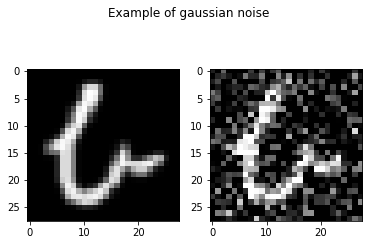

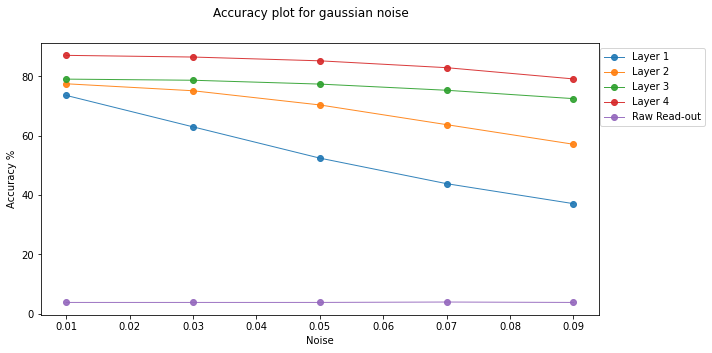

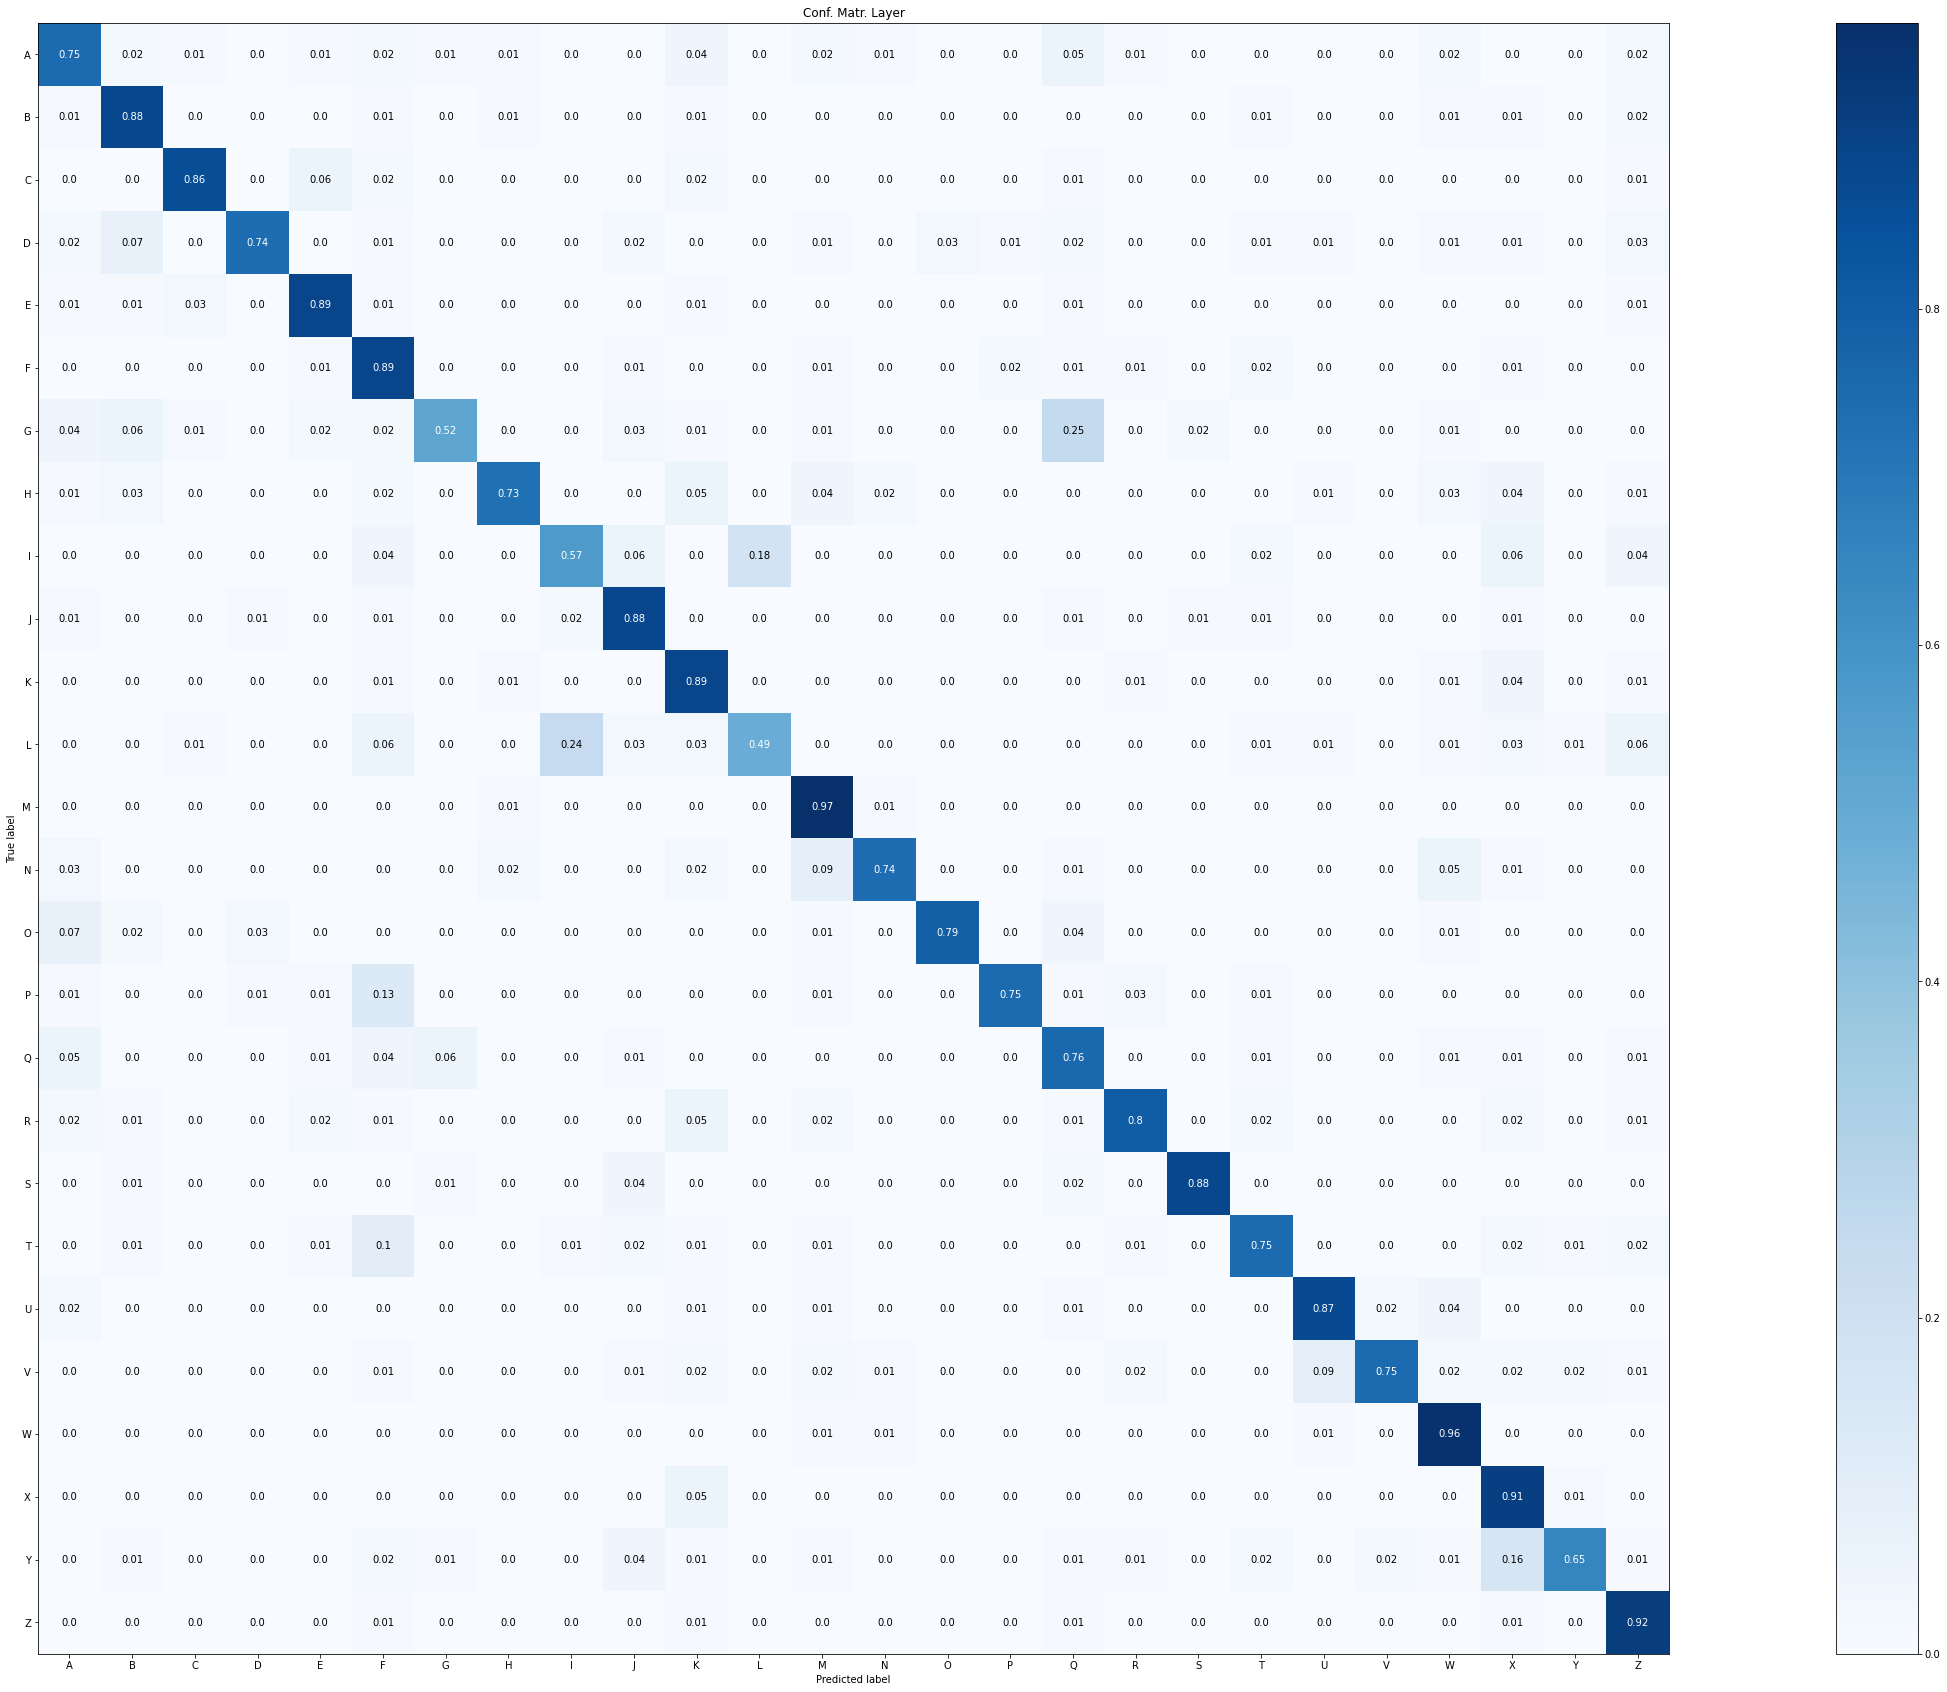

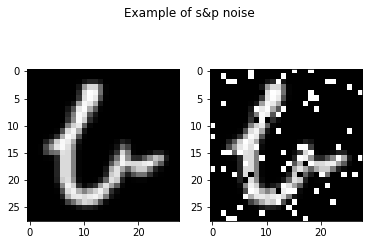

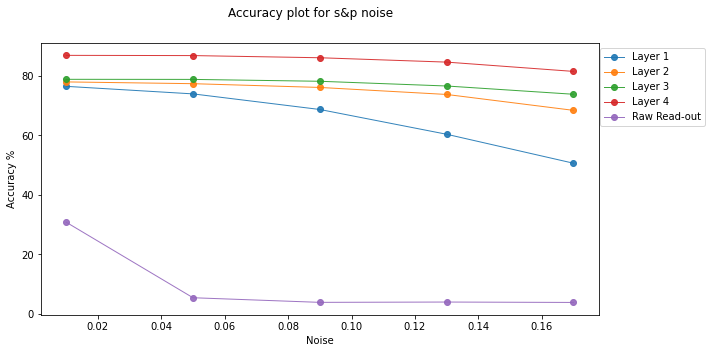

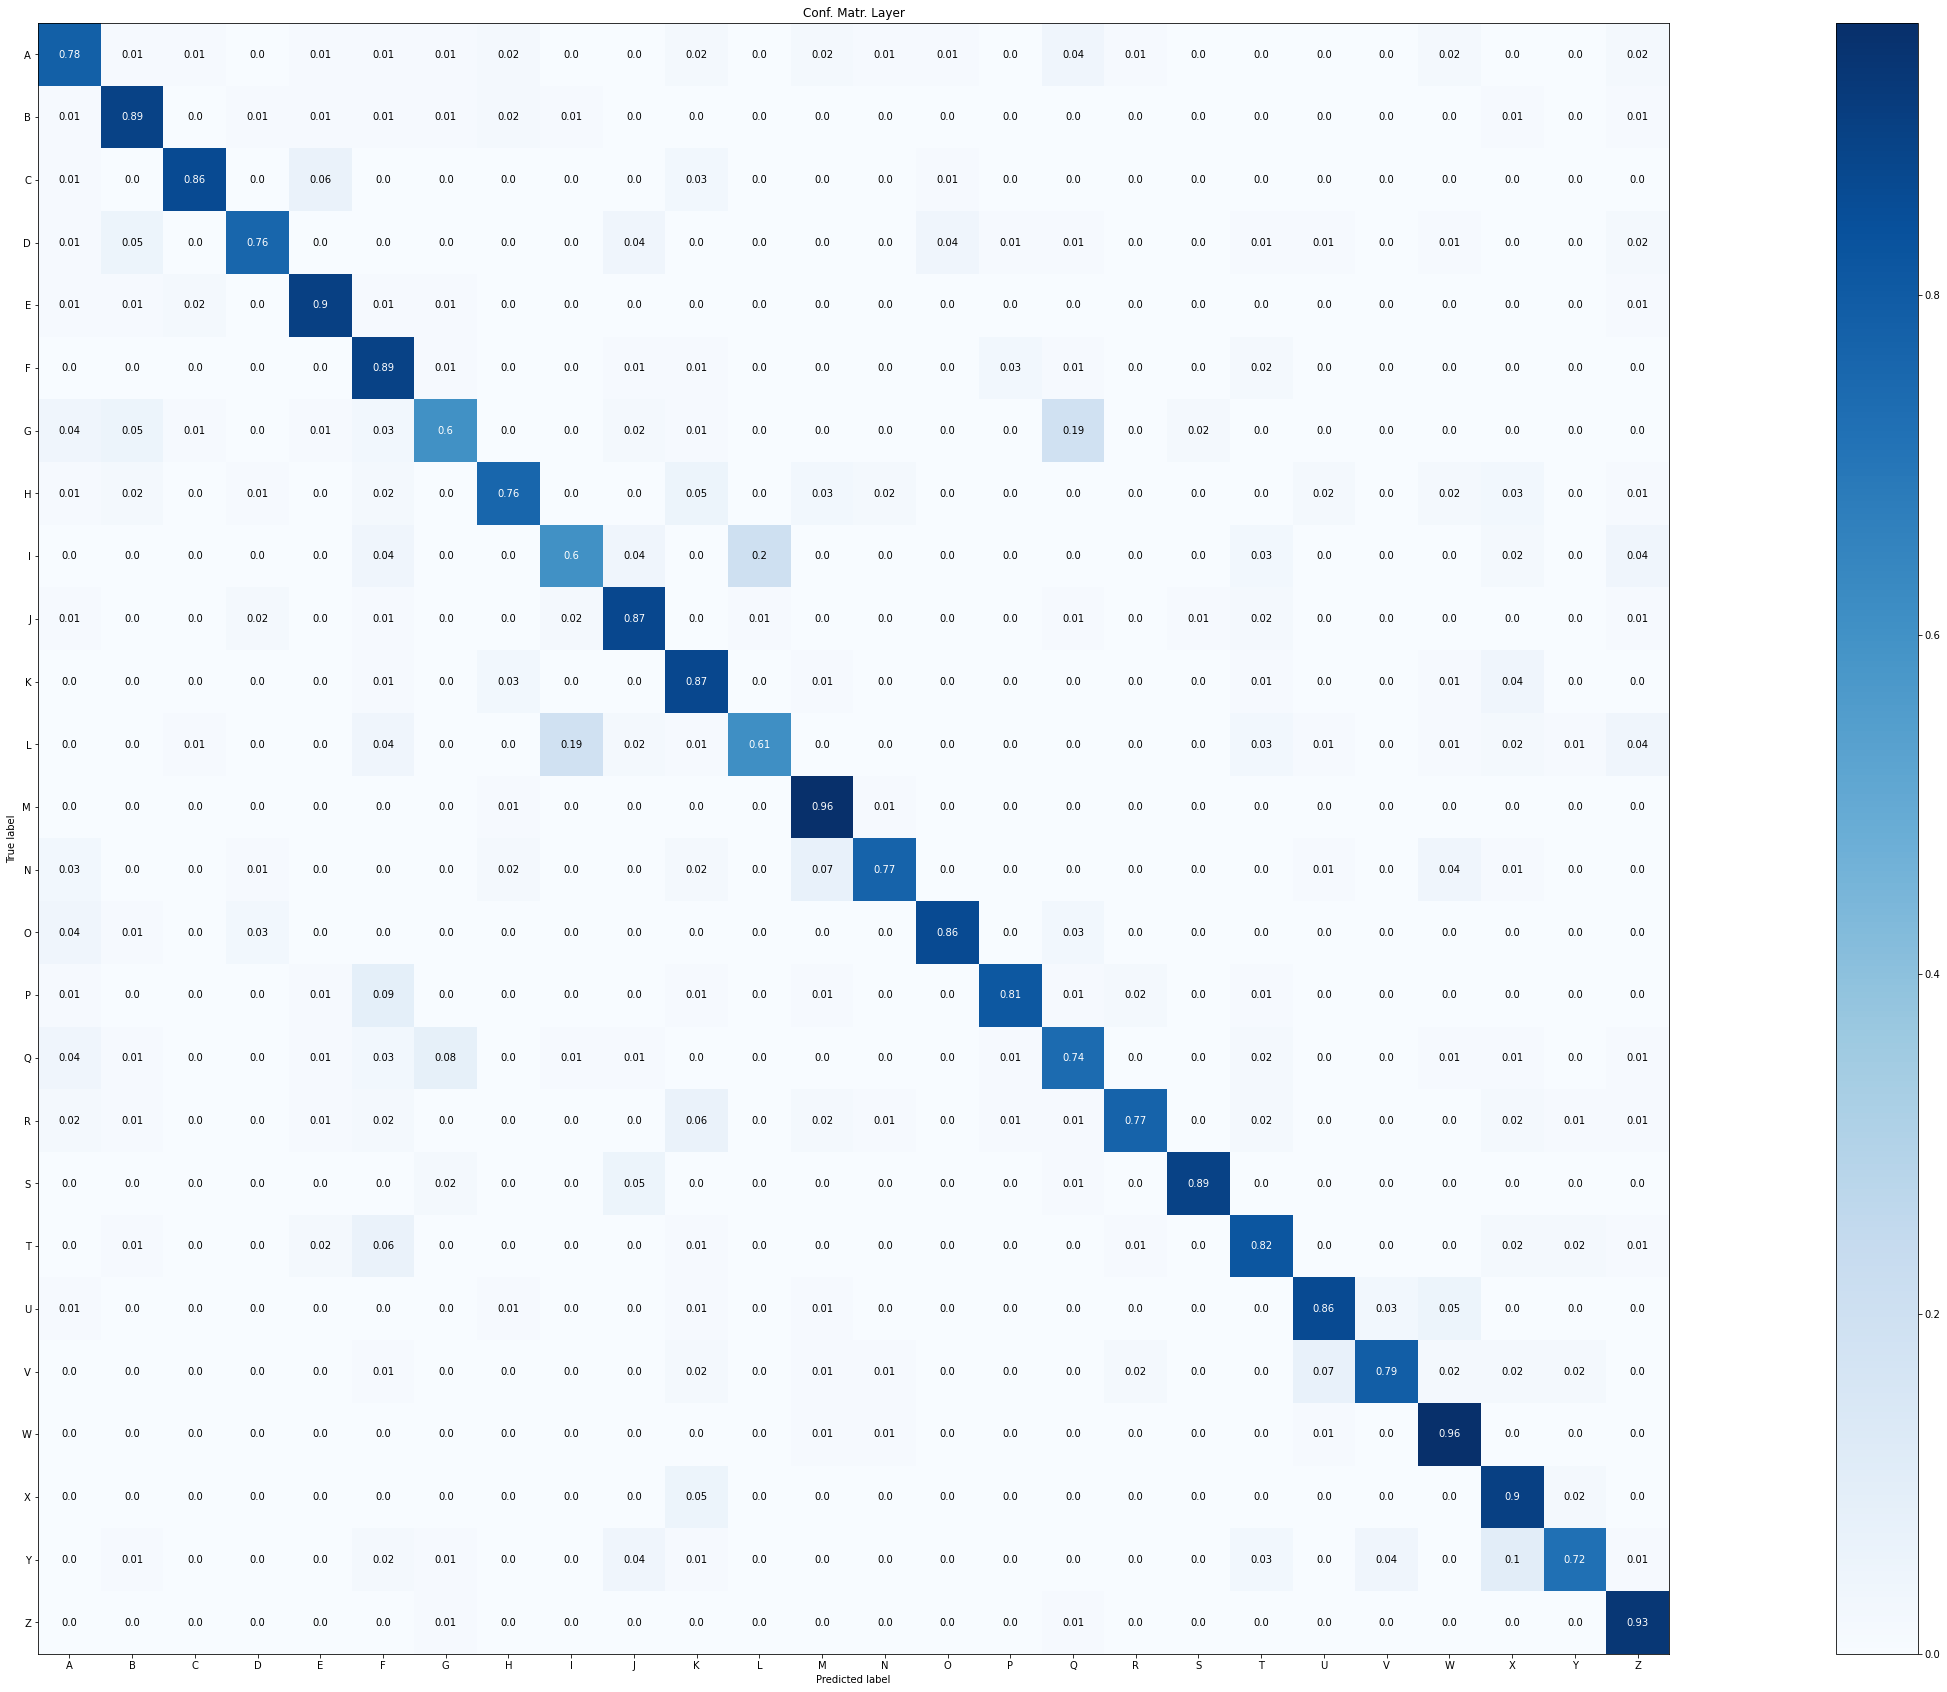

In [12]:
noise_modes = ['gaussian', 's&p']
for mode in noise_modes:
  if mode == 'gaussian':  
    step = 0.02
    stop = 0.11
    start = 0.01
  else:
    step = 0.04
    stop = 0.20
    start = 0.01
  noises = np.arange(start, stop, step)
  
  df = pd.DataFrame({'Noise': noises})
  raw_noise = []
  layer_noise = {}
  for noise in noises:
    if mode == 'gaussian':
      rnd_x_test = random_noise(x_test, mode=mode, mean=0, var=noise)
    else:
      rnd_x_test = random_noise(x_test, mode=mode, amount = noise)
    
    accuracy_rnd, _ = predict(raw_model_weights, rnd_x_test, y_test)
    raw_noise.append(accuracy_rnd.copy())
    prev_test = rnd_x_test.copy()
    n_layers = dbn_model.DN['nlayers']
    for layer_idx in range(nlayers):
        H_te_rnd = dbn_model.get_learned_map_features(prev_test, layer_idx)
        accuracy_rnd, pred_rnd = predict(layer_model_weights[layer_idx], H_te_rnd, y_test)
        key = f'Layer {layer_idx+1}'
        hist_noises = layer_noise.get(key, None)
        if hist_noises == None:
          hist_noises = []
          layer_noise[key] = hist_noises
        hist_noises.append(accuracy_rnd)
        prev_test = H_te_rnd

  for key in layer_noise.keys():
    df[key] = np.array(layer_noise[key]) *100
  df['Raw Read-out'] = np.array(raw_noise) * 100
  #sample image
  fig, ax = plt.subplots(1, 2)
  fig.suptitle("Example of {0} noise".format(mode), fontsize=12)
  ax[0].imshow(rotate(x_test[1000]), cmap='gray')
  ax[1].imshow(rotate(rnd_x_test[1000]), cmap='gray')

  #plot accuracies
  fig, axes = plt.subplots(figsize=(10, 5))
  fig.suptitle(f'Accuracy plot for {mode} noise')
  num=1
  for column in df.drop('Noise', axis=1):
    axes.plot(df['Noise'], df[column], marker='o', linewidth=1, alpha=0.9, label=column)
    num+=1
  plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
  plt.xlabel("Noise")
  plt.ylabel("Accuracy %")
  plt.show()

  #confusion matrix
  fig, axes = plt.subplots(1, 1, figsize=(60,30))
  plot_conf_matrix(y_test, pred_rnd, 'Conf. Matr. Layer', axes, namedataset)
  plt.show()

## Learning features plots
The code below does show a represantation of the features learned by the DBN layers. To visualize them better it's suggested to download the learned model and run on the matlab script provided in the folder.

In [13]:
#plot_visihidlayers(DN=dbn_model.DN, idx_layers=[3, 2, 1], n_hidden=100, figsize=(20,20))

## Clustering analysis

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tsnecuda import TSNE as TSNE_CUDA
import seaborn as sns

### GPU T-SNE

In [15]:
##GPU
tsne_cuda = TSNE_CUDA(
    n_components=2, 
    perplexity=40.0,  
    n_iter=10000, 
    verbose=1,
)

layer_idx=1
prev_test = x_test.copy()
i = 1
n_layers = dbn_model.DN['nlayers']
for layer in range(layer_idx+1):
    H_te = dbn_model.get_learned_map_features(prev_test, layer)
    prev_test = H_te

subset_rep = H_te.copy()
pca = PCA(n_components=100)
pca_result = pca.fit_transform(subset_rep)
print("PCA variance ration:")
print(pca.explained_variance_ratio_)
out_rep = np.argmax(y_test, axis=1)
print("t-SNE analysis run")
time_start = time.time()
tsne_results = tsne_cuda.fit_transform(subset_rep)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
pca_tsne_results = tsne_cuda.fit_transform(pca_result)

PCA variance ration:
[0.09 0.07 0.05 0.05 0.04 0.04 0.03 0.03 0.03 0.03 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ]
t-SNE analysis run
t-SNE done! Time elapsed: 12.495708465576172 seconds


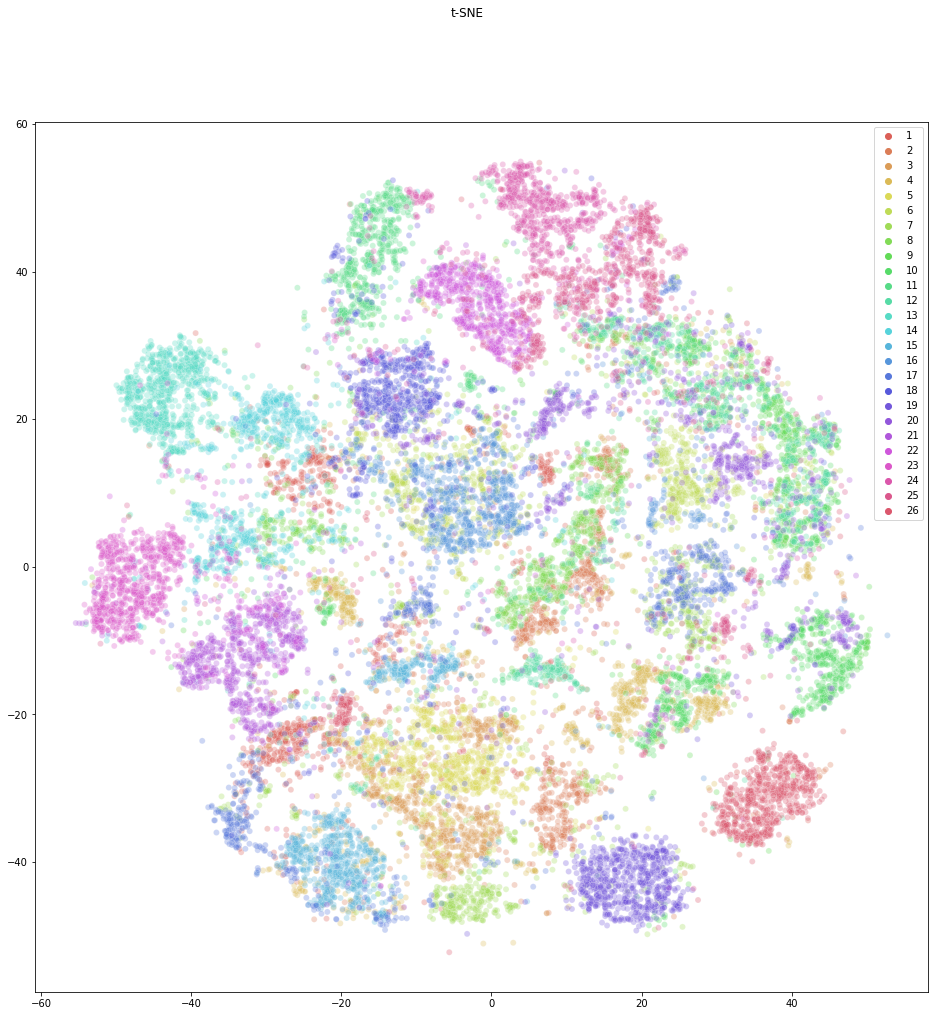

In [16]:
fig = plt.figure(figsize=(16,16))
fig.suptitle("t-SNE")
classes = NUMB_CLASSES[namedataset]
if namedataset == 'letters':
  classes = classes -1
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=out_rep,
    palette=sns.color_palette("hls", classes),
    data=subset_rep,
    legend="full",
    alpha=0.3,
    #ax=axes[0, 0]
)

Text(0.5, 0.98, 't-SNE on PCA result')

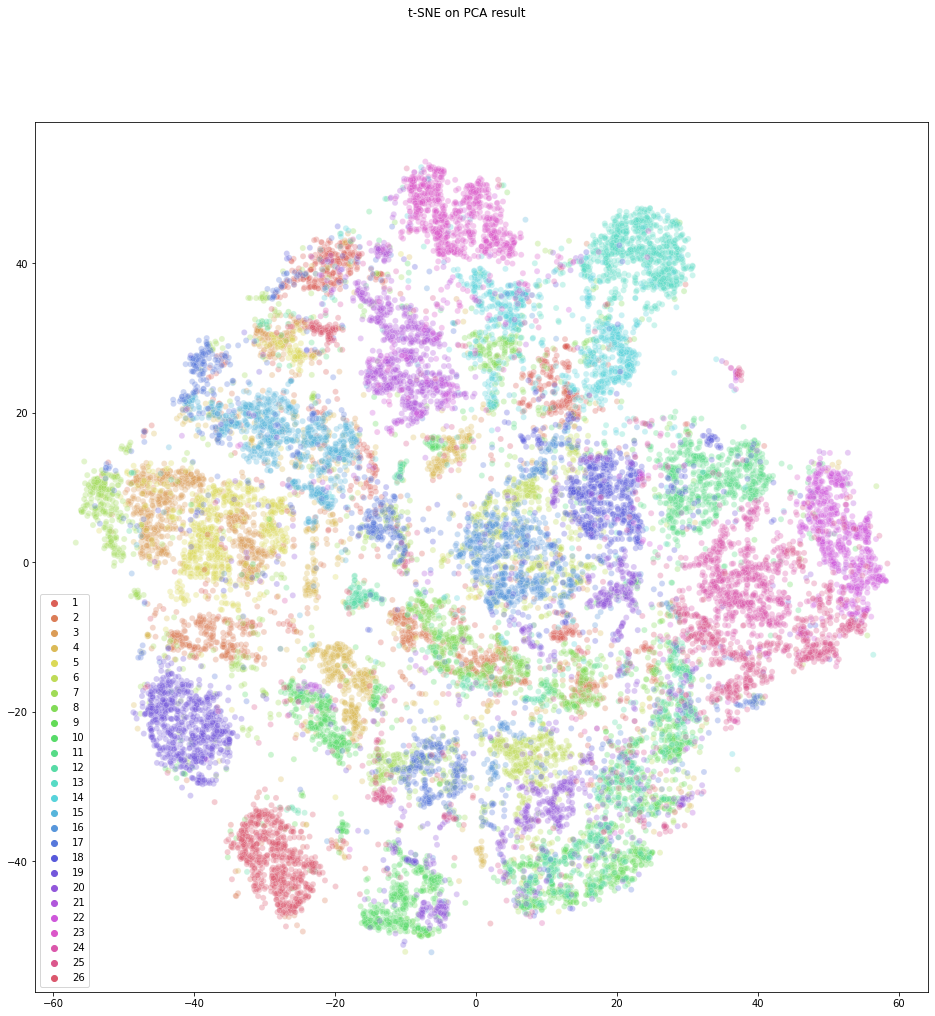

In [17]:
fig = plt.figure(figsize=(16,16))
sns.scatterplot(
    x=pca_tsne_results[:,0], y=pca_tsne_results[:,1],
    hue=out_rep,
    palette=sns.color_palette("hls", classes),
    data=subset_rep,
    legend="full",
    alpha=0.3,
)
fig.suptitle("t-SNE on PCA result")

In [18]:
del subset_rep
del pca
del pca_result
del out_rep
del pca_tsne_results
del prev_test

### CPU T-SNE

In [ ]:
layer_idx=1
prev_test = x_test.copy()
i = 1
n_layers = dbn_model.DN['nlayers']
for layer in range(layer_idx+1):
    H_te = dbn_model.get_learned_map_features(prev_test, layer)
    prev_test = H_te

#N = 10000
#idx_rnd = np.random.randint(0, high=len(x_test), size=N)
subset_rep = H_te.copy()
pca = PCA(n_components=3)
pca_result = pca.fit_transform(subset_rep)
print(pca.explained_variance_ratio_)
out_rep = np.argmax(y_test, axis=1)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(subset_rep)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
classes = NUMB_CLASSES[namedataset]
if namedataset == 'letters':
  classes = classes -1

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=out_rep,
    palette=sns.color_palette("hls", classes),
    data=subset_rep,
    legend="full",
    alpha=0.3
)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=out_rep,
    palette=sns.color_palette("hls", classes),
    data=subset_rep,
    legend="full",
    alpha=0.3
)

In [ ]:
##T-SNE on PCA
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
pca_tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_tsne_results[:,0], y=pca_tsne_results[:,1],
    hue=out_rep,
    palette=sns.color_palette("hls", classes),
    data=subset_rep,
    legend="full",
    alpha=0.3
)

### Other dataset test


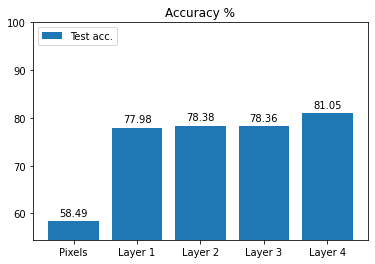

/usr/local/lib/python3.6/dist-packages/scikitplot/metrics.py:124: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


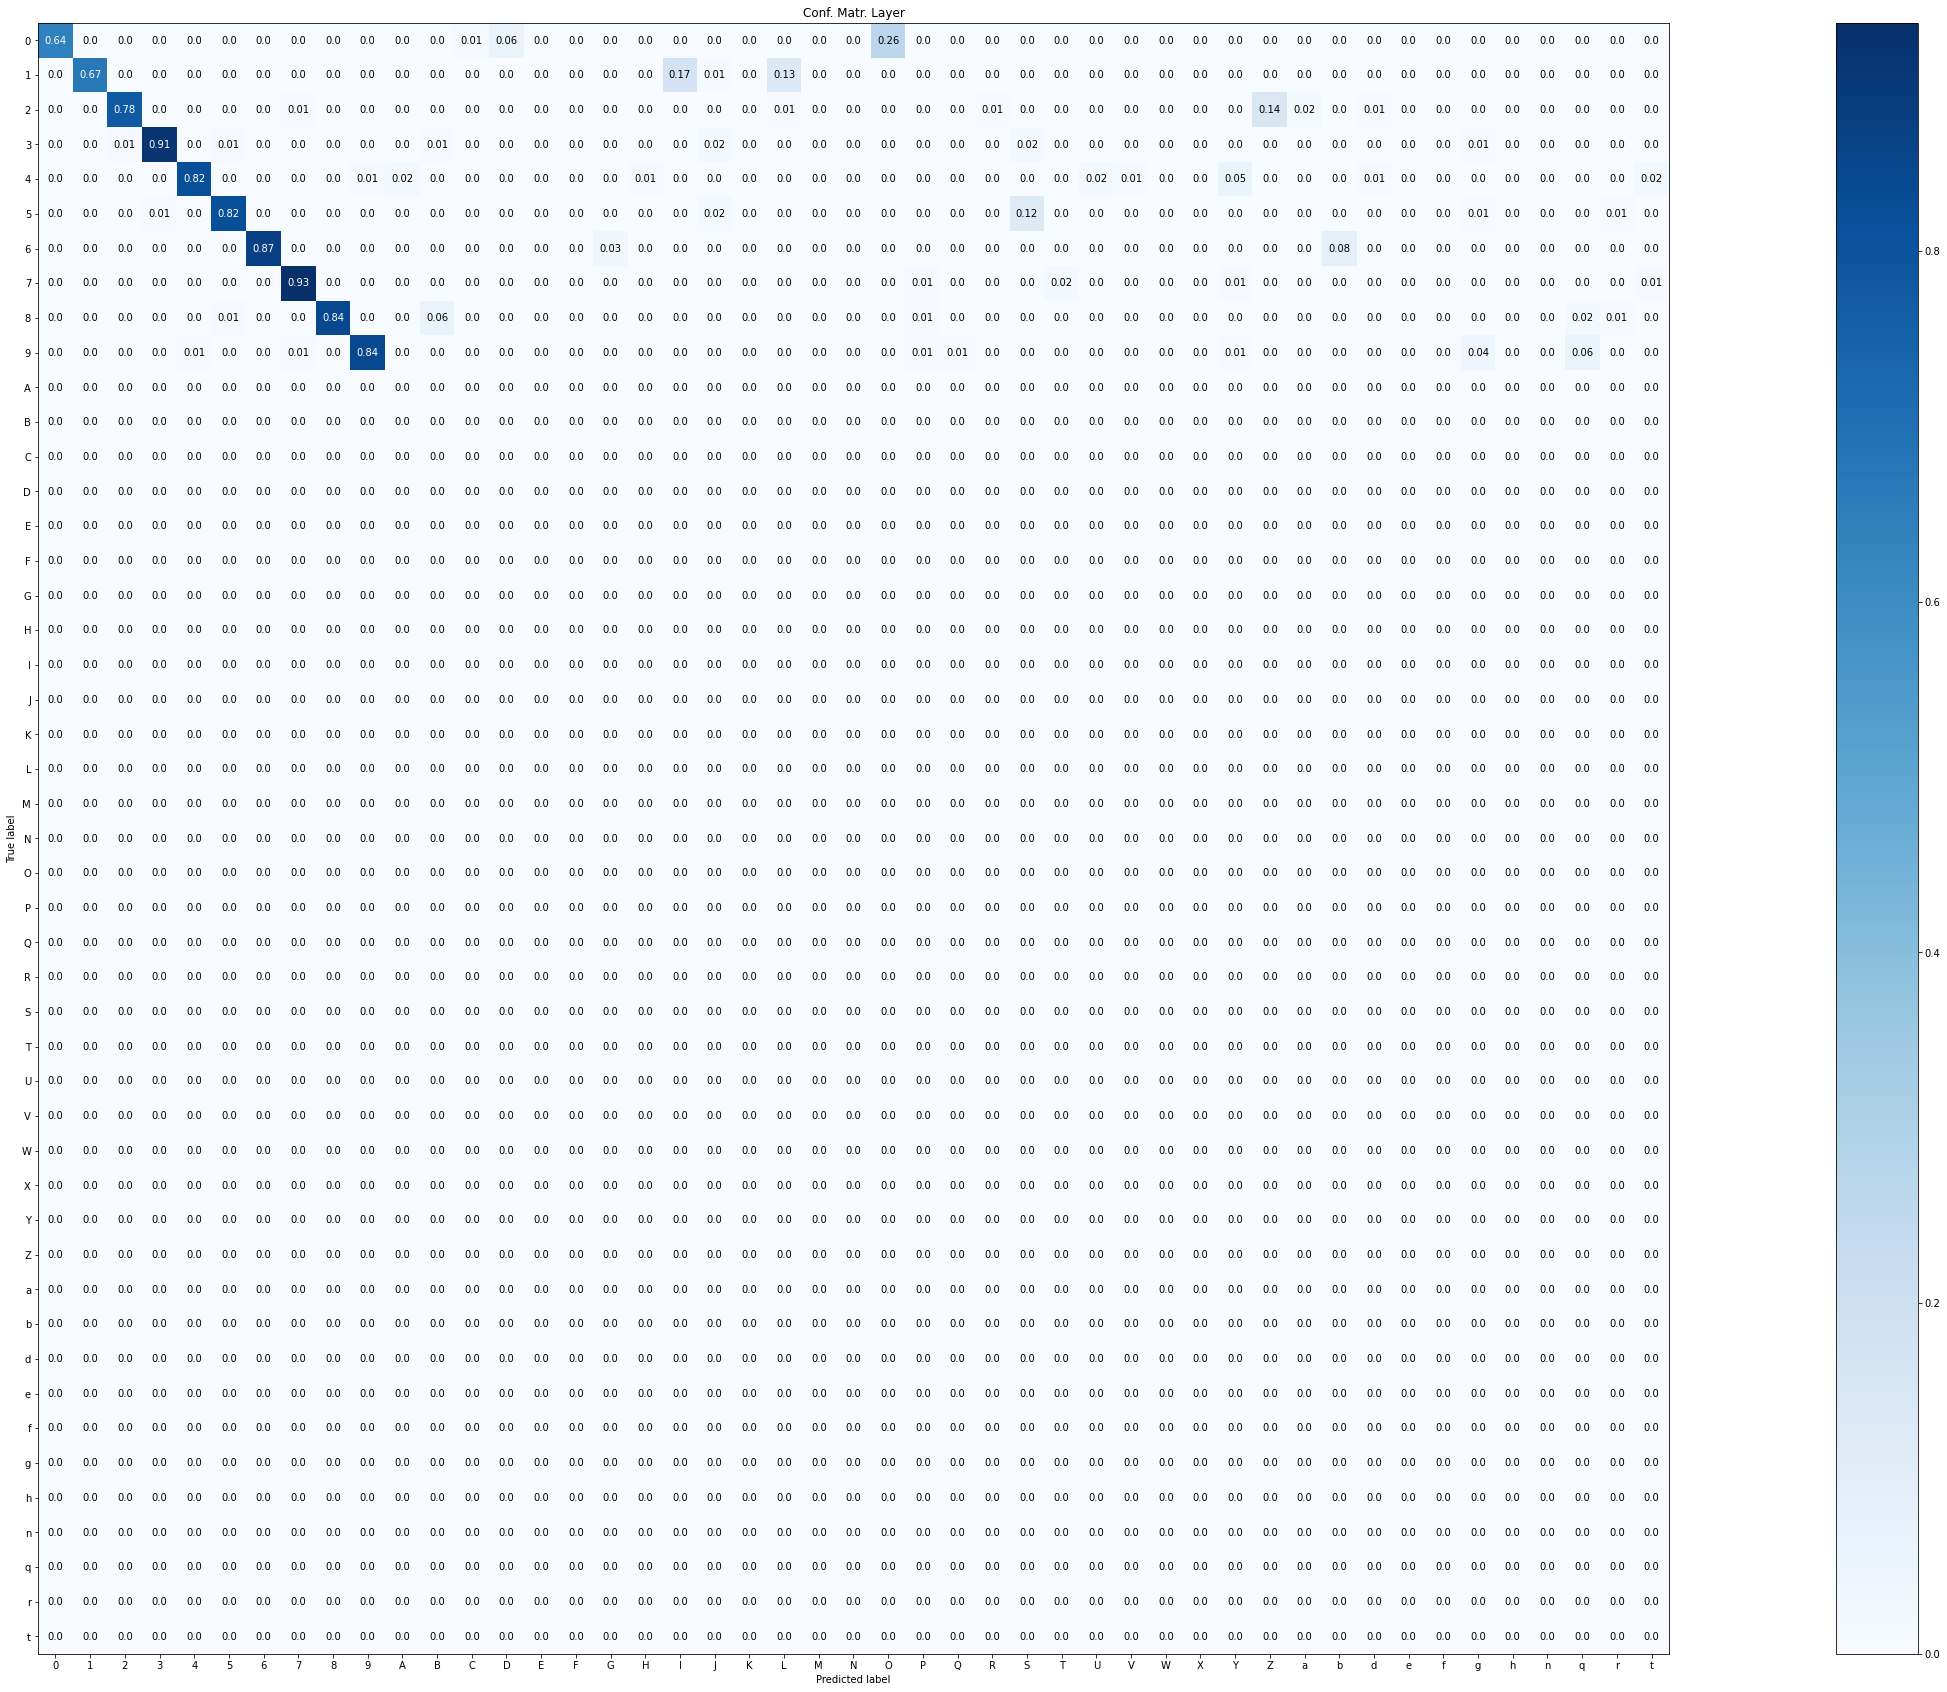

In [ ]:
namedataset = 'mnist'
_, _, x_test, y_test, _ = DBN.load_data(fname, NUMB_CLASSES[namedataset], batch_dict[namedataset])

results_noise = []
accuracy_rnd, _ = predict(raw_model_weights, x_test, y_test)
results_noise.append(accuracy_rnd.copy())
prev_test = x_test.copy()
i = 1
for layer_idx in range(nlayers):
      H_te_rnd = dbn_model.get_learned_map_features(prev_test, layer_idx)
      accuracy_rnd, pred_rnd = predict(layer_model_weights[layer_idx], H_te_rnd, y_test)
      results_noise.append(accuracy_rnd)
      prev_test = H_te_rnd
      i +=1

#bar plot accuracies
fig, axes = plt.subplots(1, 1)
results_noise = np.array(results_noise) * 100
x = np.arange(len(results_noise)) 
bar_te = axes.bar(x, np.array(results_noise), label='Test acc.')
axes.set_xticks(x)
labels = list(map(lambda value : 'Layer {0}'.format(value), x))
labels[0] = 'Pixels'
axes.set_xticklabels(labels)
axes.legend(loc='upper left')
axes.set_label("Percentage")
axes.set_title("Accuracy %")
minimum = results_noise.min()
if minimum > 5:
  minimum -= 4
axes.set_ylim(minimum, 100)
autolabel(bar_te, axes)
plt.show()

#confusion matrix
fig, axes = plt.subplots(1, 1, figsize=(60,30))
plot_conf_matrix(y_test, pred_rnd, 'Conf. Matr. Layer', axes, namedataset)
plt.show()

In [ ]:
namedataset = 'mnist'
fname = ('/home/emnist-' + namedataset + '.mat')
x_train, y_train, x_test, y_test, _ = DBN.load_data(fname, NUMB_CLASSES[namedataset], batch_dict[namedataset])

results_noise = []
accuracy, _, _ = perceptron_CPU(x_train, y_train, x_test, y_test)
H_te = dbn_model.get_learned_map_features(prev_test, layer_idx)    
results_noise.append(accuracy['te_accuracy'])
prev_train = x_train.copy()
prev_test = x_test.copy()
for layer_idx in range(nlayers):
  H_tr = dbn_model.get_learned_map_features(prev_train, layer_idx)
  H_te = dbn_model.get_learned_map_features(prev_test, layer_idx)
  accuracy, _, _ = perceptron_CPU(H_tr, y_train, H_te, y_test)
  results_noise.append(accuracy['te_accuracy'])
  prev_train = H_tr
  prev_test = H_te
  i +=1

#bar plot accuracies
fig, axes = plt.subplots(1, 1)
results_noise = np.array(results_noise) * 100
x = np.arange(len(results_noise)) 
bar_te = axes.bar(x, np.array(results_noise), label='Test acc.')
axes.set_xticks(x)
labels = list(map(lambda value : 'Layer {0}'.format(value), x))
labels[0] = 'Pixels'
axes.set_xticklabels(labels)
axes.legend(loc='upper left')
axes.set_label("Percentage")
axes.set_title("Accuracy %")
minimum = results_noise.min()
if minimum > 5:
  minimum -= 4
axes.set_ylim(minimum, 100)
autolabel(bar_te, axes)
plt.show()

#confusion matrix
fig, axes = plt.subplots(1, 1, figsize=(60,30))
plot_conf_matrix(y_test, pred_rnd, 'Conf. Matr. Layer', axes, namedataset)
plt.show()